# Featurization
This script explains the featurization procedure. Each of the provided dataframes data is cleaned first and then featurized. EDA observations and conclusions are used for featurization. These individual featurized dataframes are merged together on the application train and application test dataframes. EDA is done on the merged featurized dataframes.

## Importing libraries, modules and data

In [ ]:
# Importing the required libraries and modules
import os
import zipfile
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# step 1
"""
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com.
Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'.
This will trigger the download of kaggle.json, a file containing your API credentials.
# step 2 """
!pip install -q kaggle
# step 3
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swapnilransing","key":"da755409e0fa021f4c2ad42a892e0ae9"}'}

In [ ]:
# step 4 : creating a directory
!mkdir ~/.kaggle # !rm -rf ~/.kaggle is the command if the directory is already present
# step 5 :copy the file kaggle.json to created directory
!cp kaggle.json ~/.kaggle/
# step 6: permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# step 7 : downloading the particular files
! kaggle competitions download -c home-credit-default-risk

 99% 681M/688M [00:07<00:00, 98.1MB/s]
100% 688M/688M [00:07<00:00, 99.5MB/s]


In [ ]:
# step 8 : unzipping
source_dir = '/content/'
os.chdir(source_dir)

file_names = os.listdir(source_dir)
for item in file_names:
  if (item.endswith(".zip")):
    file_name = os.path.abspath(item) # get full path of files
    zip_ref = zipfile.ZipFile(file_name) # create zipfile object
    zip_ref.extractall(source_dir) # extract file to dir
    zip_ref.close() # close file
    os.remove(file_name) # delete zipped file

## Defining the functions

In [ ]:
#Function for reducing the memory usage of dataframe
def reduce_mem_usage(data, verbose = True):
    #Reference: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.

    Inputs=
    data= name of the dataframe

    Outputs=
    Memory reduced dataframe

    '''

    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
        col_type = data[col].dtype

        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)

    return data

In [ ]:
# Function for plotting category variable
def category_var_plot(dataframe,category_var):
  """ This function plots the categorical variables of dataframe.

  Inputs=
  dataframe= name of the dataframe
  category_var= name of the categorical variable

  Outputs=
  1. Computes the unique categories of a variable
  2. Computes the NaN sample percentage
  3. percentage Count plot of variable categories
  4. Binary classification perentage plot of each category of categorical variable
  5.pie chart of percentage count of defaulters in dataframe variable

  """

  # 1. Computing the unique categories of a variable

  print("Number of unique category values of {} categorical variable are {}".format(category_var,dataframe[category_var].nunique()))
  nunique=dataframe[category_var].nunique()
  print('-'*185)

  # 2. Computing the NaN sample percentage
  list_unique_cat=dataframe[category_var].unique().tolist()
  counter=0
  for i in list_unique_cat:
    if str(i)=='nan':
      print("Dataframe has NaN rows.")
      df=dataframe[dataframe[category_var].isna()]
      print("Percentage of NaN rows for {} categorical variable are {} %".format(category_var,round(df["SK_ID_CURR"].count()/dataframe["SK_ID_CURR"].count()*100,2)))

      print("Percentage of {} labels for NaN value row is {} %".format(df["TARGET"].value_counts().index.tolist()[0],round(df["TARGET"].value_counts()[0]/df["SK_ID_CURR"].count()*100,2)))
      print("Percentage of {} labels for NaN value row is {} %".format(df["TARGET"].value_counts().index.tolist()[1],round(df["TARGET"].value_counts()[1]/df["SK_ID_CURR"].count()*100,2)))
      print("Applicants labelled 1 are defaulters.")
      counter=1
      break
  if counter==0:
    print("Dataframe does not have NaN rows.")

  print('-'*185)

  # 3. percentage Count plot of variable categories
  df=dataframe.groupby(category_var, dropna=False)["SK_ID_CURR"].count()
  df = df.rename('percent').reset_index()
  df['percent'] = (df['percent'] / df['percent'].sum()) * 100
  ylim=df['percent'].max()+5

  g = sns.catplot(x=category_var,y='percent',kind='bar',data=df)
  g.ax.set_ylim(0,ylim)
  g.fig.set_figheight(4.5)
  g.fig.set_figwidth(29)
  g.set_xticklabels(rotation=90)

  for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() # controls the height
    txt_y = p.get_height() # controls the x axis position
    g.ax.text(txt_x,txt_y+0.5,txt)

  plt.title("Percentage distribution of each category in {} variable".format(category_var))
  plt.ylabel("Percentage(%)")
  plt.xlabel(category_var)
  plt.show()

  print('-'*185)

  # 4. Binary classification perentage plot of each category of categorical variable
  df=dataframe.groupby(category_var, dropna=False)["TARGET"].value_counts(normalize=True)
  df=df.mul(100)
  df = df.rename('percent').reset_index()
  df_non_defaulters=df[df["TARGET"]==0]
  df_defaulters=df.groupby(category_var)["TARGET"].sum()
  df_defaulters=df_defaulters.mul(100)
  df_defaulters=df_defaulters.rename('percent').reset_index()

        # set the figure size
  plt.figure(figsize=(24,4.5))

        # bar chart 1 -> top bars (group of 'Defaulters')
  bar1 = sns.barplot(x=category_var,  y="percent", data=df_defaulters, color='darkblue')

        # bar chart 2 -> bottom bars (group of 'Non-Defaulters')
  bar2 = sns.barplot(x=category_var, y="percent", data=df_non_defaulters, color='lightblue')

        # add legend
  top_bar = mpatches.Patch(color='darkblue', label='Defaulters')
  bottom_bar = mpatches.Patch(color='lightblue', label='Non-Defaulters')
  plt.legend(handles=[top_bar, bottom_bar])

        # show the graph
  plt.title("Binary classification perentage of each category for {} categorical variable".format(category_var))
  plt.ylabel("Percentage(%)")
  plt.xlabel(category_var)
  plt.ylim(0,130)
  plt.xticks(rotation=90)
  plt.show()

  print('-'*185)

  # 5.pie chart of percentage count of defaulters in dataframe variable
  # dataset preperation for pie chart
  df=dataframe.groupby(category_var)["TARGET"].value_counts()
  df = df.rename('count').reset_index()
  df_defaulters_pie=df[df["TARGET"]==1]

  # plotting
  plt.figure(figsize=(10, 10))

  #define Seaborn color palette to use
  colors = sns.color_palette('pastel')[0:nunique]

  #create pie chart
  plt.pie(df_defaulters_pie["count"], labels = df_defaulters_pie[category_var], colors = colors, autopct='%.0f%%')
  plt.title("Defaulters Perentage of Each Category For {} Categorical Variable".format(category_var))
  plt.show()

In [ ]:
# Function to plot bar plot of percentage NaN values in a dataframe
def plot_nan_pct(dataframe,title):
  '''
  Function plots bar plot representing percentage of NaN values in a dataframe.
  This function first computes all the variable/columns of dataframe consisting of NaN
  values and then computes the corresponding percentage and plots that percentage values.

  Inputs=
  dataframe= DataFrame name
  title= data frame name entered as string (This will be used in bar plot title)

  Outputs=
  1. Bar plot ot percentage of NaN values in a dataframe
    '''

  nan_col_name=[]
  nan_val_count=[]
  nan_value_dict={}

  # prepering a dictionary of columns and correponding NaN percentage
  for i in range(dataframe.shape[1]):
    count=round(dataframe[dataframe[dataframe.columns[i]].isna()].shape[0]/dataframe.shape[0]*100,2)
    if count!=0:
      nan_value_dict[dataframe.columns[i]]=count
  # sorting the dict in reverse order and storing the column name and NaN percentage in lists
  for w in sorted(nan_value_dict, key=nan_value_dict.get, reverse=True):
    nan_val_count.append(nan_value_dict[w])
    nan_col_name.append(w)

  if len(nan_val_count)>0:
    print("Number of variables having NaN samples are ",len(nan_col_name))
    # generating the plot
    fig = plt.figure(figsize = (25, 5))

    # creating the bar plot
    plt.bar(nan_col_name, nan_val_count, color ='maroon')

    plt.xlabel("Variable Name")
    plt.ylabel("Percentage (%)")
    plt.title("Percentage of NaN values in "+title)
    plt.xticks(rotation = 90)
    plt.show()

  else:
    print("Dataframe {} does not have any NaN variable".format(title))

In [ ]:
# Function for plotting continuous variable
def plot_continuous_variables(data, column_name, scale="No", scale_range=(0,5),box_scale=(0,5)):
  """ This function plots the continuous variables of dataframe.

  Inputs=
  data= name of the dataframe
  column_name= name of the continuous variable
  scale=If you want to set the scale for the output plots, please mention Yes
  scale_range= Range for probability density plot, default is (0,5) if scale!=No
  box_scale= Range of box plot, default is (0,5) if scale!=No

  Outputs=
  1. Computes the NaN sample percentage
  2. Probability density plot
  3. Box plot
  """


  # 1. Computes the NaN sample percentage
  count=data[data[column_name].isna()].shape[0]
  if count!=0:
    print("Continuous variable {} has {} NaN rows.".format(column_name,count))
    df=data[data[column_name].isna()]

    print("Percentage of NaN rows for {} continuous variable are {} %".format(column_name,round(df["SK_ID_CURR"].count()/data["SK_ID_CURR"].count()*100,2)))

    if df["TARGET"].value_counts().shape[0]>1:
      print("Percentage of {} labels for NaN value row is {} %".format(df["TARGET"].value_counts().index.tolist()[0],round(df["TARGET"].value_counts()[0]/df["SK_ID_CURR"].count()*100,2)))
      print("Percentage of {} labels for NaN value row is {} %".format(df["TARGET"].value_counts().index.tolist()[1],round(df["TARGET"].value_counts()[1]/df["SK_ID_CURR"].count()*100,2)))
      print("Applicants labelled 1 are defaulters.")
    else:
      print("All the labels of NaN rows are ",df["TARGET"].value_counts().index.tolist()[0])

  else:
    print("Continuous variable {} does not have NaN rows.".format(column_name))

  print('-'*185)

  sns.set_style('whitegrid')
  plt.figure(figsize=(20,8))

  # 2. Probability density plot
  plt.subplot(1, 2, 1)
  plt.subplots_adjust(wspace=0.25)

  sns.distplot(data[column_name][data['TARGET'] == 0].dropna(),label='Non-Defaulters', hist = False, color='red')
  sns.distplot(data[column_name][data['TARGET'] == 1].dropna(),label='Defaulters', hist = False, color='black')
  plt.xlabel(column_name)
  plt.ylabel('Probability Density')
  plt.legend(fontsize='medium')
  plt.title("Dist-Plot of {}".format(column_name))
  if scale !="No":
    plt.xlim(scale_range)


  # 3. Box plot
  plt.subplot(1, 2, 2)
  plt.subplots_adjust(wspace=0.25)
  g =sns.boxplot(x='TARGET', y=column_name, data=data)
  plt.title("Box-Plot of {}".format(column_name))
  g.set_xticklabels(['Non-Defaulters','Defaulters'])
  if scale !="No":
    plt.ylim(box_scale)

  plt.show()

In [ ]:
# Function for pair plot
def pairPlotFn(dataframe,NameString):
  """
  This function plots the pair plot.

  Inputs:
  dataframe: Name of the dataframe of which pair plot is to be plotted
  NameString: Pair plot name

  Output:
  Pair Plot
  """
  g = sns.pairplot(df, hue="TARGET", markers=["o", "s"],size=4)
  #g.fig.set_figheight(15)
  #g.fig.set_figwidth(15)
  plt.suptitle("Pair Plot of {} Dataframes Top Continuous Variables".format(NameString), size = 22,y=1.02)
  plt.show()

In [ ]:
# Frequency encoding function
dummydataframe=pd.DataFrame()
def freq_encoding(df,categorical_column_list,df2=dummydataframe):
  """
  This function does frequency encoding of categorical variable
  Inputs:
  1. df = dataframe
  2. categorical_column_list = list of categorical columns in a dataframe which needs to be encoded
  3. df2 = dataframe 2 which needs to be transformed based on the df encoding

  Outputs:
  Encoded dataframe and dataframe 2
  """
  for column in categorical_column_list:
    if column in df.columns:
      fe=df.groupby(column, dropna=False).size()/len(df)*100
      df.loc[:,column+'_Freq_Encode']=df[column].map(fe)
      df.drop(column, axis=1, inplace=True)
      if df2.shape[0] != 0:
        df2.loc[:,column+'_Freq_Encode']=df2[column].map(fe)
        df2.drop(column, axis=1, inplace=True)
  if df2.shape[0] == 0:
    return df
  else:
    return df,df2

In [ ]:
# Automated Label encoding function
def label_encoding(df,categorical_column_list,df2=dummydataframe):
  """
  This function does label encoding of categorical variable
  Inputs:
  1. df = dataframe
  2. categorical_column_list = list of categorical columns in a dataframe which needs to be encoded
  3. df2 = dataframe 2 which needs to be transformed based on the df encoding

  Outputs:
  Encoded dataframe and dataframe 2
  """
  for column in categorical_column_list:
    if column in df.columns:
      encoding_dict=dict([(j,i) for i,j in enumerate(df[column].unique(),0)])
      df[column] = df[column].map(encoding_dict)
      if df2.shape[0] != 0:
        df2[column] = df2[column].map(encoding_dict)
  if df2.shape[0] == 0:
    return df
  else:
    return df,df2

In [ ]:
#One hot encoding function
def ohe_encoding(df,categorical_column_list,df2=dummydataframe):
  """
  This function does one hot encoding of categorical variable
  Inputs:
  1. df = dataframe
  2. categorical_column_list = list of categorical columns in a dataframe which needs to be encoded
  3. df2 = dataframe 2 which needs to be transformed based on the df encoding

  Outputs:
  Encoded dataframe and dataframe 2
  """
  for column in categorical_column_list:
    if column in df.columns:
      column_ohe = pd.get_dummies(df[column], prefix = column)
      df = pd.concat([df.drop([column], axis = 1),column_ohe], axis = 1)

      if df2.shape[0] != 0:
        column_ohe = pd.get_dummies(df2[column], prefix = column)
        df2 = pd.concat([df2.drop([column], axis = 1),column_ohe], axis = 1)
        # add the missing columns in df2
        missing_cols=set()
        missing_cols = set(df.columns) - set(df2.columns)  # Missing columns from df2
        # Add a missing column in df2 with default value equal to 0
        if len(missing_cols)!=0:
          for c in missing_cols:
            df2[c] = 0

        # add the missing columns in df
        missing_cols=set()
        missing_cols = set(df2.columns) - set(df.columns)  # Missing columns from df
        # Add a missing column in df with default value equal to 0
        if len(missing_cols)!=0:
          for c in missing_cols:
            df[c] = 0

        # Ensure the order of column in the df2 is in the same order than in df
        df2 = df2[df.columns]

  if df2.shape[0] == 0:
    return df
  else:
    return df,df2

## Columns Description of Each Dataframes

In [ ]:
columns=pd.read_csv("HomeCredit_columns_description.csv",encoding='latin1')
columns

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [ ]:
pd.options.display.max_colwidth = 200
print(columns["Description"][columns["Row"]=='TARGET'])

1    Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
Name: Description, dtype: object


# Featurization Of Individual Dataframes

## Featurizing bureau balance dataframe

This dataframe tells the status of credit in credit bureau. The status is mentioned relative to the application date. Following preprocessing and feature engineering is performed on this dataframe:
1. Bureau balance dataframe has monthwise status information of each credit bureau. As status shows the ordinal behavior, it is label encoded.
2. For each of the credit in this dataframe, simple moving average, weighted moving average and exponential moving average are calculated for a one year timeframe.
3. Age variables are created to understand the historical date of a particular bureau loan status.
3. Aggregated bureau balance dataframe is generated by aggregating the created variables on each of the credit ID (SK_ID_BUREAU) in the dataframe. Different aggregation functions are used for the variables based on the variables definition and domain knowledge.
4. Aggregated dataframe's NaN values are replaced with 0 based on the literature survey.

In [ ]:
bureau_balance=pd.read_csv("bureau_balance.csv")
bureau_balance=reduce_mem_usage(bureau_balance)
bureau_balance.head()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 624.85 MB
Memory usage after optimization: 338.46 MB
Decreased by 45.8%
----------------------------------------------------------------------------------------------------


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
bureau_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

Bureau balance dataframe has information about the credit record ID and its monthwise credit status. Credit status can have any of the 8 different values recorded for credit record ID for each month of the available months data. 0 is the most recent month and -1 is recent than -2 and so on. Status takes values as C= closed, X = unknown status, 0 = no dpd, 1 = dpd 1 to 30, 2= dpd 31 to 60 and so on.

DPD or Days Past Due shows the number of days by which you have missed an EMI or credit card payment. If you have made timely payments in the past, your DPD will be mentioned as ‘0’. DPD shows how disciplined you have been in making EMI payments in the past. https://www.paisabazaar.com/cibil/days-past-due-dpd-cibil-report/

We will label encode the status, and will assign higher values to the high dpd. As status x is unknown we will assign a median value giving a benifit of doubt. Following dictionary we can use for label encoding:

{ 'C': 0, '0': 1, '1': 2, 'X': 3, '2': 3, '3': 4, '4': 5, '5': 6}

We will use mean, max, min, exponential moving average aggregation techniques for status column in the bureau balance table.


In [ ]:
## Creating age variables:
# variable eg. age_bureau_c_first= wrt the current application, when in the history does a bureau loan first time shown status = closed (c) in months
# variable eg. age_bureau_c_last= wrt the current application, when in the history does a bureau loan last time shown status = closed (c) in months
print('Starting Age variable creation')
Bureau_Balance_process_start_time=datetime.now()
# lets convert the months in the absolute values and add 1 so that it does not show error while calculating age and aggragations
bureau_balance['MONTHS_BALANCE']=abs(bureau_balance['MONTHS_BALANCE'])+1

# Lets create one hot encoded columns of status for which age variables will be derived
# These ohe column are multiplied by months balance
# then min and max month value is derived while group by 	SK_ID_BUREAU which is age variable value
# Min value of OHE will always be 0. This is avoided by replacing 0 with Nan so that we get correct min values of all required age variable
bureau_balance["age_bureau"]=bureau_balance["STATUS"]
bureau_balance = pd.get_dummies(bureau_balance, columns=['age_bureau', ])
bureau_balance.iloc[:,3:] = bureau_balance.iloc[:,3:].multiply(bureau_balance["MONTHS_BALANCE"], axis="index")
bureau_balance.iloc[:,3:]=bureau_balance.iloc[:,3:].replace(0, np.nan)

print('Age variable creation processed in',datetime.now() - Bureau_Balance_process_start_time)
print("-"*80)

### Categorical feature encoding of bureau balance dataframe
# 1. Manual Label encoding (Ordinal behavior)
print('Starting Categorical Feature Encoding')
print('Starting Label encoding')
Bureau_Balance_process_start_time_enc=datetime.now()

status_dict = { 'C': 0, '0': 1, '1': 2, 'X': 3, '2': 3, '3': 4, '4': 5, '5': 6}
bureau_balance['STATUS'] = bureau_balance['STATUS'].map(status_dict)
print('Categorical feature encoding is processed in',datetime.now() - Bureau_Balance_process_start_time_enc)
print("-"*80)

print('Starting moving average calculations')
Bureau_Balance_process_MA_start_time=datetime.now()
# Aggregation techniques on bureau_balance dataframe

# For calculating Simple moving average (SMA), weighted moving average (WMA) and Exponential moving average (EMA)
# we want recent month to get a higher weightage in calculation. So as to achieve this, lets sort the
# values in descending order of Months Balance.
bureau_balance=bureau_balance.sort_values(by=['SK_ID_BUREAU','MONTHS_BALANCE'], ascending=[0,0])
bureau_balance=bureau_balance.reset_index().drop(["index"], axis=1) # resetting the index

temp_df=bureau_balance.groupby('SK_ID_BUREAU')['STATUS']
bureau_balance['EMA']=temp_df.transform(lambda x: x.ewm(span=12).mean())
weights = np.arange(1,13)
bureau_balance['WMA']=temp_df.transform(lambda x: x.rolling(12).apply(lambda statuses: np.dot(statuses, weights)/weights.sum(), raw=True))
bureau_balance['SMA']=temp_df.transform(lambda x: x.rolling(12).mean())

print('Moving average calculations is processed in',datetime.now() - Bureau_Balance_process_MA_start_time)
print("-"*80)

#Defining the required aggregation dictionary
print('Starting Continuous Feature Encoding')
print('Starting Aggregation calculations')
Bureau_Balance_process_AG_start_time=datetime.now()
aggregations_dict = {
            'MONTHS_BALANCE' : ['mean','max'],
            'STATUS' : ['mean','max','last'],
            'EMA' : ['last'],
            'WMA' : ['last'],
            'SMA' : ['last'],
            'age_bureau_0' : ['min','max'],
            'age_bureau_1' : ['min','max'],
            'age_bureau_2' : ['min','max'],
            'age_bureau_3' : ['min','max'],
            'age_bureau_4' : ['min','max'],
            'age_bureau_5' : ['min','max'],
            'age_bureau_C' : ['min','max'],
            'age_bureau_X' : ['min','max']}
#aggregating over whole dataset first
aggregated_bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU']).agg(aggregations_dict)
aggregated_bureau_balance.columns = ['_'.join(ele).upper() for ele in aggregated_bureau_balance.columns]

#filling the missing values obtained after aggregations with 0
aggregated_bureau_balance.fillna(0, inplace = True)

print('Aggregation calculations is processed in',datetime.now() - Bureau_Balance_process_AG_start_time)
print("-"*80)

# Lets get the exponential decay variable
# This decay variable give a higher value to the historically last status and lower value to the historically first status
# eg. If the loan is closed recently, It will get a low value and if it is closed long time back will get a high value
# eg. If the loan is DPD since from long time will get a high value
print('Starting Decay variable calculations')
Bureau_Balance_process_decay_start_time=datetime.now()

aggregated_bureau_balance['AGE_BUREAU_C_MIN_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_C_MIN'])
aggregated_bureau_balance['AGE_BUREAU_C_MAX_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_C_MAX'])
aggregated_bureau_balance['AGE_BUREAU_0_MIN_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_0_MIN'])
aggregated_bureau_balance['AGE_BUREAU_0_MAX_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_0_MAX'])
aggregated_bureau_balance['AGE_BUREAU_X_MIN_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_X_MIN'])
aggregated_bureau_balance['AGE_BUREAU_X_MAX_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_X_MAX'])
aggregated_bureau_balance['AGE_BUREAU_1_MIN_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_1_MIN'])
aggregated_bureau_balance['AGE_BUREAU_1_MAX_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_1_MAX'])
aggregated_bureau_balance['AGE_BUREAU_2_MIN_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_2_MIN'])
aggregated_bureau_balance['AGE_BUREAU_2_MAX_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_2_MAX'])
aggregated_bureau_balance['AGE_BUREAU_3_MIN_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_3_MIN'])
aggregated_bureau_balance['AGE_BUREAU_3_MAX_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_3_MAX'])
aggregated_bureau_balance['AGE_BUREAU_4_MIN_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_4_MIN'])
aggregated_bureau_balance['AGE_BUREAU_4_MAX_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_4_MAX'])
aggregated_bureau_balance['AGE_BUREAU_5_MIN_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_5_MIN'])
aggregated_bureau_balance['AGE_BUREAU_5_MAX_EXP']=np.exp(aggregated_bureau_balance['AGE_BUREAU_5_MAX'])

print('Decay variable calculations is processed in',datetime.now() - Bureau_Balance_process_decay_start_time)
print("-"*80)

print('Total processing time for bureau balance dataframe is :',datetime.now() - Bureau_Balance_process_start_time)
print("-"*80)

print('Head rows from aggregated bureau balance dataframes are')
aggregated_bureau_balance=reduce_mem_usage(aggregated_bureau_balance)
aggregated_bureau_balance.head()

Starting Age variable creation
Age variable creation processed in 0:00:16.386052
--------------------------------------------------------------------------------
Starting Categorical Feature Encoding
Starting Label encoding
Categorical feature encoding is processed in 0:00:01.141654
--------------------------------------------------------------------------------
Starting moving average calculations
Moving average calculations is processed in 0:20:04.552506
--------------------------------------------------------------------------------
Starting Continuous Feature Encoding
Starting Aggregation calculations
Aggregation calculations is processed in 0:00:05.778336
--------------------------------------------------------------------------------
Starting Decay variable calculations
Decay variable calculations is processed in 0:00:00.293971
--------------------------------------------------------------------------------
Total processing time for bureau balance dataframe is : 0:20:28.159082
--

,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_MAX,STATUS_MEAN,STATUS_MAX,STATUS_LAST,EMA_LAST,WMA_LAST,SMA_LAST,AGE_BUREAU_0_MIN,AGE_BUREAU_0_MAX,...,AGE_BUREAU_1_MIN_EXP,AGE_BUREAU_1_MAX_EXP,AGE_BUREAU_2_MIN_EXP,AGE_BUREAU_2_MAX_EXP,AGE_BUREAU_3_MIN_EXP,AGE_BUREAU_3_MAX_EXP,AGE_BUREAU_4_MIN_EXP,AGE_BUREAU_4_MAX_EXP,AGE_BUREAU_5_MIN_EXP,AGE_BUREAU_5_MAX_EXP
SK_ID_BUREAU,,,,,,,,,,,,,,,,,,,,,
5001709,49.0,97,0.340088,3,0,0.000001,0.000000,0.00,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5001710,42.0,83,1.144531,3,0,0.000654,0.000000,0.00,49.0,54.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5001711,2.5,4,1.500000,3,3,1.630859,0.000000,0.00,2.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5001712,10.0,19,0.526367,1,0,0.188354,0.076904,0.25,10.0,19.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5001713,11.5,22,3.000000,3,3,3.000000,3.000000,3.00,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# Lets understand the NA value statistics of dataframes - Check for NaN values of a variables
#NaN variable percentatge in dataframe
plot_nan_pct(aggregated_bureau_balance,"Bureau Balance")

Dataframe Bureau Balance does not have any NaN variable


In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+"aggregated_bureau_balance.pickle","wb")
pickle.dump(aggregated_bureau_balance, pickle_out)
pickle_out.close()
# Delete the non required variables to free up memory
del bureau_balance,aggregated_bureau_balance

In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_in=open(pickle_path+"aggregated_bureau_balance.pickle","rb")
aggregated_bureau_balance=pickle.load(pickle_in)
pickle_in.close()

## Featurizing Bureau dataframe
This dataframe consists of client's previous credits provided by other financial institutions that were reported to Credit Bureau.
For every loan in sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. Following preprocessing and feature engineering is performed on this dataframe:
1. EDA has shown that there are categories in the categorical variable whose count is low. These almost 0 count categories are merged into a single categories to limit the one hot encoding vector length.

2. Categorical variables in the Bureau dataframe are "CREDIT_ACTIVE","CREDIT_CURRENCY","CNT_CREDIT_PROLONG","CREDIT_TYPE".
These are one hot encoded.

3. EDA observation about the continuous variable value range is used to limit the range of few of the continuous variables.

4. Continuous variables are created based on the reference. These consists of both age and velocity variables.

5. After these steps, bureau balance dataframe is left merged on the bureau dataframe.

6. Aggregated bureau dataframe is generated by aggregating the created variables on each of the client application ID (SK_ID_CURR) in the dataframe. Different aggregation functions are used for the variables based on the variables definition and domain knowledge.

4. Aggregated dataframe's NaN values are replaced with 0 based on the literature survey.

In [ ]:
bureau=pd.read_csv("bureau.csv")
bureau=reduce_mem_usage(bureau)
bureau

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 222.62 MB
Memory usage after optimization: 112.95 MB
Decreased by 49.3%
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,9.132300e+04,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,2.250000e+05,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,4.643235e+05,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,9.000000e+04,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2.700000e+06,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,1.125000e+04,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2432.0,-2492.0,5476.5,0,3.813084e+04,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,1.557000e+04,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,3.600000e+04,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [ ]:
# Merging the categories in categorical variables which has almost 0 count.
print('Replacing Low count of CREDIT_ACTIVE categories by Low_Count category')
print('Unique values of CREDIT_ACTIVE are \n',bureau['CREDIT_ACTIVE'].unique())
bureau['CREDIT_ACTIVE']=bureau['CREDIT_ACTIVE'].replace(['Sold','Bad debt'],'Low_Count')
print('Unique values of CREDIT_ACTIVE after replacing low count categories are \n',bureau['CREDIT_ACTIVE'].unique())
print('--'*60)

print('Replacing Low count of CREDIT_CURRENCY categories by Low_Count category')
print('Unique values of CREDIT_CURRENCY are \n',bureau['CREDIT_CURRENCY'].unique())
bureau['CREDIT_CURRENCY']=bureau['CREDIT_CURRENCY'].replace(['currency 2','currency 4','currency 3'],'Low_Count')
print('Unique values of CREDIT_CURRENCY after replacing low count categories are \n',bureau['CREDIT_CURRENCY'].unique())
print('--'*60)

print('Replacing Low count of CNT_CREDIT_PROLONG categories by 1 category')
print('Unique values of CNT_CREDIT_PROLONG are \n',bureau['CNT_CREDIT_PROLONG'].unique())
bureau['CNT_CREDIT_PROLONG']=bureau['CNT_CREDIT_PROLONG'].replace([1,2,3,4,5,6,7,8,9],1)
print('Unique values of CNT_CREDIT_PROLONG after replacing low count categories are \n',bureau['CNT_CREDIT_PROLONG'].unique())
print('--'*60)

print('Replacing Low count of CREDIT_TYPE categories by Low_Count category')
print('Unique values of CREDIT_TYPE are \n',bureau['CREDIT_TYPE'].unique())
bureau['CREDIT_TYPE']=bureau['CREDIT_TYPE'].replace(['Cash loan (non-earmarked)','Interbank credit','Loan for purchase of shares (margin lending)',
                                                      'Loan for the purchase of equipment','Loan for working capital replenishment','Mobile operator loan',
                                                      'Real estate loan', 'Unknown type of loan'],'Low_Count')
print('Unique values of CREDIT_TYPE after replacing low count categories are \n',bureau['CREDIT_TYPE'].unique())

Replacing Low count of CREDIT_ACTIVE categories by Low_Count category
Unique values of CREDIT_ACTIVE are 
 ['Closed' 'Active' 'Sold' 'Bad debt']
Unique values of CREDIT_ACTIVE after replacing low count categories are 
 ['Closed' 'Active' 'Low_Count']
------------------------------------------------------------------------------------------------------------------------
Replacing Low count of CREDIT_CURRENCY categories by Low_Count category
Unique values of CREDIT_CURRENCY are 
 ['currency 1' 'currency 2' 'currency 4' 'currency 3']
Unique values of CREDIT_CURRENCY after replacing low count categories are 
 ['currency 1' 'Low_Count']
------------------------------------------------------------------------------------------------------------------------
Replacing Low count of CNT_CREDIT_PROLONG categories by 1 category
Unique values of CNT_CREDIT_PROLONG are 
 [0 2 1 4 3 5 9 8 6 7]
Unique values of CNT_CREDIT_PROLONG after replacing low count categories are 
 [0 1]
-----------------------

In [ ]:
### Categorical feature encoding of bureau balance dataframe
# 1. one hot encoding feturizzation of categorical features
print("Starting the categorical feature encoding of dataframe")
process_start_time=datetime.now()

ohe_cat_columns=['CREDIT_ACTIVE',"CREDIT_CURRENCY",'CREDIT_TYPE']
bureau=ohe_encoding(bureau,ohe_cat_columns)

print('Categorical feature encoding is processed in',datetime.now() - process_start_time)
print("-"*80)

### Continuous feature encoding
print('Starting Continuous Feature Encoding')
process_start_cnt_time=datetime.now()
# lets convert the days credit value to positive value
bureau['DAYS_CREDIT']=abs(bureau['DAYS_CREDIT'])
# Box plots plotted in EDA has shown that few of the continuous variables have large range of values. lets replace these values by nan
bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] > -50*365] = np.nan
bureau['DAYS_ENDDATE_FACT'][bureau['DAYS_ENDDATE_FACT'] > -50*365] = np.nan
bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] > -50*365] = np.nan
# Featurization - These features are generated refering the mentioned link
# Reff: https://github.com/rishabhrao1997/Home-Credit-Default-Risk/blob/main/Feature%20Engineering%20and%20Modelling.ipynb
bureau['CREDIT_DURATION'] = np.abs(bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE'])
bureau['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1 for ele in bureau['CREDIT_DAY_OVERDUE']]
bureau['MAX_AMT_OVERDUE_DURATION_RATIO'] = bureau['AMT_CREDIT_MAX_OVERDUE'] / (bureau['CREDIT_DURATION'] + 0.00001)
bureau['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / (bureau['CREDIT_DURATION'] + 0.00001)
bureau['AMT_OVERDUE_DURATION_LEFT_RATIO'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / (bureau['DAYS_CREDIT_ENDDATE'] + 0.00001)
bureau['CNT_PROLONGED_MAX_OVERDUE_MUL'] = bureau['CNT_CREDIT_PROLONG'] * bureau['AMT_CREDIT_MAX_OVERDUE']
bureau['CNT_PROLONGED_DURATION_RATIO'] = bureau['CNT_CREDIT_PROLONG'] / (bureau['CREDIT_DURATION'] + 0.00001)
bureau['CURRENT_DEBT_TO_CREDIT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / (bureau['AMT_CREDIT_SUM'] + 0.00001)
bureau['CURRENT_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['AMT_ANNUITY_CREDIT_RATIO'] = bureau['AMT_ANNUITY'] / (bureau['AMT_CREDIT_SUM'] + 0.00001)
bureau['CREDIT_ENDDATE_UPDATE_DIFF'] = np.abs(bureau['DAYS_CREDIT_UPDATE'] - bureau['DAYS_CREDIT_ENDDATE'])

#Lets merge aggregated_bureau_balance with Bureau data frame before aggregating the bureau dataframe
bureau_merged = bureau.merge(aggregated_bureau_balance, on = 'SK_ID_BUREAU', how = 'left')

#Defining the required aggregation dictionary
Bureau_process_start_time=datetime.now()
print('Starting Aggregation calculations')
## Velocity variable calculations
# 1. Count of creadit bureau loan wrt each application
# 2. Count of creadit bureau loans which are closed/Active/LowCount at the time of application wrt each application
# 3. Count of creadit bureau loans which are currency 1/low currency t at the time of application wrt each application
# 4. Count of creadit bureau loans which are different CREDIT_TYPE at the time of application wrt each application
# All of these are being calculated at the time of aggregation

aggregations_dict = {
                         # velocity variable
                        'SK_ID_BUREAU' : ['count'],
                        'CREDIT_ACTIVE_Active' : ['sum'],
                        'CREDIT_ACTIVE_Closed' : ['sum'],
                        'CREDIT_ACTIVE_Low_Count' : ['sum'],
                        'CREDIT_CURRENCY_Low_Count' : ['sum'],
                        'CREDIT_CURRENCY_currency 1' : ['sum'],
                        'CREDIT_TYPE_Another type of loan' : ['sum'],
                        'CREDIT_TYPE_Car loan' : ['sum'],
                        'CREDIT_TYPE_Consumer credit' : ['sum'],
                        'CREDIT_TYPE_Credit card' : ['sum'],
                        'CREDIT_TYPE_Loan for business development' : ['sum'],
                        'CREDIT_TYPE_Low_Count' : ['sum'],
                        'CREDIT_TYPE_Microloan' : ['sum'],
                        'CREDIT_TYPE_Mortgage' : ['sum'],
                        'DAYS_CREDIT' : ['mean','min','max'],
                        'CREDIT_DAY_OVERDUE' : ['mean', 'min','max'],
                        'DAYS_CREDIT_ENDDATE' : ['mean','min','max'],
                        'DAYS_ENDDATE_FACT' : ['mean','min'],
                        'AMT_CREDIT_MAX_OVERDUE': ['max','mean','sum'],
                        'CNT_CREDIT_PROLONG': ['max','sum'],
                        'AMT_CREDIT_SUM' : ['sum','max','mean'],
                        'AMT_CREDIT_SUM_DEBT': ['sum','mean'],
                        'AMT_CREDIT_SUM_LIMIT': ['max','sum'],
                        'AMT_CREDIT_SUM_OVERDUE': ['max','sum'],
                        'DAYS_CREDIT_UPDATE' : ['mean','min'],
                        'AMT_ANNUITY' : ['mean','sum','max'],
                        'CREDIT_ACTIVE_Active' : ['mean'],
                        'CREDIT_ACTIVE_Closed' : ['mean'],
                        'CREDIT_ACTIVE_Low_Count' : ['mean'],
                        'CREDIT_CURRENCY_Low_Count' : ['mean'],
                        'CREDIT_CURRENCY_currency 1' : ['mean'],
                        'CREDIT_TYPE_Another type of loan' : ['mean'],
                        'CREDIT_TYPE_Car loan' : ['mean'],
                        'CREDIT_TYPE_Consumer credit' : ['mean'],
                        'CREDIT_TYPE_Credit card' : ['mean'],
                        'CREDIT_TYPE_Loan for business development' : ['mean'],
                        'CREDIT_TYPE_Low_Count' : ['mean'],
                        'CREDIT_TYPE_Microloan' : ['mean'],
                        'CREDIT_TYPE_Mortgage' : ['mean'],
                        'CREDIT_DURATION' : ['max','mean'],
                        'FLAG_OVERDUE_RECENT': ['sum'],
                        'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max', 'mean'],
                        'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean','max'],
                        'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                        'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                        'CURRENT_CREDIT_DEBT_DIFF' : ['mean','min'],
                        'AMT_ANNUITY_CREDIT_RATIO' : ['mean','max','min'],
                        'CREDIT_ENDDATE_UPDATE_DIFF' : ['max','min'],
                        'MONTHS_BALANCE_MEAN' : ['mean'],
                        'MONTHS_BALANCE_MAX' : ['mean','max'],
                        'STATUS_MEAN' : ['mean'],
                        'STATUS_MAX' : ['mean','max'],
                        'STATUS_LAST' : ['mean','last'],
                        'EMA_LAST' : ['mean','last'],
                        'WMA_LAST' : ['mean','last'],
                        'SMA_LAST' : ['mean','last']}
#aggregating over whole dataset first
aggregated_bureau = bureau_merged.groupby(['SK_ID_CURR']).agg(aggregations_dict)
aggregated_bureau.columns = ['_'.join(ele).upper() for ele in aggregated_bureau.columns]

#filling the missing values obtained after aggregations with 0
aggregated_bureau.fillna(0, inplace = True)

print('Continuous variable feature encoding is processed in',datetime.now() - process_start_cnt_time)
print("-"*80)
print('Total processing time for bureau dataframe is :',datetime.now() - process_start_time)
print("-"*80)

print('Head rows from aggregated bureau dataframe are')
aggregated_bureau=reduce_mem_usage(aggregated_bureau)
aggregated_bureau.head()

Starting the categorical feature encoding of dataframe
Categorical feature encoding is processed in 0:00:01.497146
--------------------------------------------------------------------------------
Starting Continuous Feature Encoding
Starting Aggregation calculations
Continuous variable feature encoding is processed in 0:00:08.277271
--------------------------------------------------------------------------------
Total processing time for bureau dataframe is : 0:00:09.778121
--------------------------------------------------------------------------------
Head rows from aggregated bureau dataframe are
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 131.24 MB
Memory usage after optimization: 61.83 MB
Decreased by 52.9%
----------------------------------------------------------------------------------------------------


,SK_ID_BUREAU_COUNT,CREDIT_ACTIVE_ACTIVE_MEAN,CREDIT_ACTIVE_CLOSED_MEAN,CREDIT_ACTIVE_LOW_COUNT_MEAN,CREDIT_CURRENCY_LOW_COUNT_MEAN,CREDIT_CURRENCY_CURRENCY 1_MEAN,CREDIT_TYPE_ANOTHER TYPE OF LOAN_MEAN,CREDIT_TYPE_CAR LOAN_MEAN,CREDIT_TYPE_CONSUMER CREDIT_MEAN,CREDIT_TYPE_CREDIT CARD_MEAN,...,STATUS_MAX_MEAN,STATUS_MAX_MAX,STATUS_LAST_MEAN,STATUS_LAST_LAST,EMA_LAST_MEAN,EMA_LAST_LAST,WMA_LAST_MEAN,WMA_LAST_LAST,SMA_LAST_MEAN,SMA_LAST_LAST
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7,0.428467,0.571289,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000,...,2.427734,3.0,0.571289,1.0,0.662109,1.000000,0.212524,0.000000,0.226196,0.0
100002,8,0.250000,0.750000,0.0,0.0,1.0,0.0,0.0,0.500000,0.500000,...,2.625000,3.0,0.250000,0.0,1.164062,1.287109,0.765625,1.333008,0.864746,1.5
100003,4,0.250000,0.750000,0.0,0.0,1.0,0.0,0.0,0.500000,0.500000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
100004,2,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
100005,3,0.666504,0.333252,0.0,0.0,1.0,0.0,0.0,0.666504,0.333252,...,2.333984,3.0,1.333008,3.0,1.062500,1.780273,0.119629,0.000000,0.194458,0.0


In [ ]:
# Lets understand the NA value statistics of dataframes - Check for NaN values of a variables
#NaN variable percentatge in dataframe
plot_nan_pct(aggregated_bureau,"Bureau")

Dataframe Bureau does not have any NaN variable


In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+"aggregated_bureau.pickle","wb")
pickle.dump(aggregated_bureau, pickle_out)
pickle_out.close()
# Delete the non required variables to free up memory
del bureau_merged,aggregated_bureau

## Featurizing previous application dataframe
This dataframe have all previous applications for Home Credit loans of clients who have applied for loan. Following preprocessing and feature engineering is performed on this dataframe:
1. Categorical features are encoded using frequency encoding, one hot encoding and label encoding.
  
  Categorical features which do not show ordinal behavior and has high number of categories are frequency encoded.
  
  Categorical features which do not show ordinal behavior and has low number of categories are one hot encoded. This is choosen to limit the number of features in a dataframe.

  Categorical features which show ordinal behavior are label encoded.

3. EDA observation about the continuous variable value range is used to limit the range of few of the continuous variables.

4. Continuous variables are created based on the reference.

6. Aggregated previous application dataframe is generated by aggregating the created variables on each of the client application ID (SK_ID_CURR) in the dataframe. Different aggregation functions are used for the variables based on the variables definition and domain knowledge.

4. Aggregated dataframe's NaN values are replaced with 0 based on the literature survey.


In [ ]:
previous_application=pd.read_csv("previous_application.csv")
previous_application=reduce_mem_usage(previous_application)

previous_application.head()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 471.48 MB
Memory usage after optimization: 309.01 MB
Decreased by 34.5%
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
### Categorical feature encoding
print("Starting the categorical feature encoding of dataframe")
Prev_appl_process_start_time=datetime.now()

# 1. Frequency encoding of categorical features (7 to 10 classes)
freq_cat_column=["PRODUCT_COMBINATION","CODE_REJECT_REASON","NAME_CASH_LOAN_PURPOSE","NAME_TYPE_SUITE"]
previous_application=freq_encoding(previous_application,freq_cat_column)

# 2. One hot encoding of categorical columns (upto 5 classes)
ohe_cat_columns=['NAME_CONTRACT_TYPE','WEEKDAY_APPR_PROCESS_START','NAME_PAYMENT_TYPE','NAME_PORTFOLIO',
                 'NAME_PRODUCT_TYPE']
previous_application=ohe_encoding(previous_application,ohe_cat_columns)

# 3. Manual Label encoding the Categorical feature (Ordinal behavior)
label_encode_dict = {"NAME_CONTRACT_STATUS": {'Approved': 0, 'Refused' : 3, 'Canceled' : 2, 'Unused offer' : 1},
                "FLAG_LAST_APPL_PER_CONTRACT": { 'Y':1,'N':0},
                "NAME_CLIENT_TYPE":{'Repeater':0, 'New':3, 'Refreshed':1, 'XNA':2},
                "NAME_YIELD_GROUP":{'middle':3, 'low_action':1, 'high':4, 'low_normal':2, 'XNA':0}}

previous_application=previous_application.replace(label_encode_dict)

# 4. Using Label encoding function for label encoding the Categorical feature (More than 10 classes)
label_cat_column=["NAME_GOODS_CATEGORY","CHANNEL_TYPE","NAME_SELLER_INDUSTRY"]
previous_application=label_encoding(previous_application,label_cat_column)

print("Finished the categorical feature encoding of dataframe in ",datetime.now()-Prev_appl_process_start_time)
print("-"*100)

### Continuous variable and featurization
print("Starting the Continuous variable featurization")
Prev_appl_process_cnt_start_time=datetime.now()

# Featurization of continuous variables of previous application dataframe
# From EDA we have found out that DAYS_LAST_DUE_1ST_VERSION variable has outliers, lets remove these outliers
previous_application["DAYS_LAST_DUE_1ST_VERSION"][previous_application["DAYS_LAST_DUE_1ST_VERSION"]>=365*50]=np.nan
#engineering some features on domain knowledge
previous_application['MISSING_VALUES_TOTAL_PREV'] = previous_application.isna().sum(axis = 1)
previous_application['AMT_DECLINED'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']
previous_application['AMT_CREDIT_GOODS_RATIO'] = previous_application['AMT_CREDIT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)
previous_application['AMT_CREDIT_GOODS_DIFF'] = previous_application['AMT_CREDIT'] - previous_application['AMT_GOODS_PRICE']
previous_application['AMT_CREDIT_APPLICATION_RATIO'] = previous_application['AMT_APPLICATION'] / (previous_application['AMT_CREDIT'] + 0.00001)
previous_application['CREDIT_DOWNPAYMENT_RATIO'] = previous_application['AMT_DOWN_PAYMENT'] / (previous_application['AMT_CREDIT'] + 0.00001)
previous_application['GOOD_DOWNPAYMET_RATIO'] = previous_application['AMT_DOWN_PAYMENT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)
previous_application['INTEREST_DOWNPAYMENT'] = previous_application['RATE_DOWN_PAYMENT'] * previous_application['AMT_DOWN_PAYMENT']
previous_application['INTEREST_CREDIT'] = previous_application['AMT_CREDIT'] * previous_application['RATE_INTEREST_PRIMARY']
previous_application['INTEREST_CREDIT_PRIVILEGED'] = previous_application['AMT_CREDIT'] * previous_application['RATE_INTEREST_PRIVILEGED']
previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = previous_application['AMT_APPLICATION'] / (previous_application['DAYS_DECISION'] + 0.00001) * -1
previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = previous_application['AMT_APPLICATION'] / (previous_application['SELLERPLACE_AREA'] + 0.00001)
previous_application['ANNUITY'] = previous_application['AMT_CREDIT'] / (previous_application['CNT_PAYMENT'] + 0.00001)
previous_application['ANNUITY_GOODS'] = previous_application['AMT_GOODS_PRICE'] / (previous_application['CNT_PAYMENT'] + 0.00001)
previous_application['DAYS_FIRST_LAST_DUE_DIFF' ] = previous_application['DAYS_LAST_DUE'] - previous_application['DAYS_FIRST_DUE']
previous_application['AMT_CREDIT_HOUR_PROCESS_START'] = previous_application['AMT_CREDIT'] * previous_application['HOUR_APPR_PROCESS_START']
previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = previous_application['AMT_CREDIT'] * previous_application['NFLAG_LAST_APPL_IN_DAY']
previous_application['AMT_CREDIT_YIELD_GROUP'] = previous_application['AMT_CREDIT'] * previous_application['NAME_YIELD_GROUP']
#https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
previous_application['AMT_INTEREST'] = previous_application['CNT_PAYMENT'] * previous_application[
                                                'AMT_ANNUITY'] - previous_application['AMT_CREDIT']
previous_application['INTEREST_SHARE'] = previous_application['AMT_INTEREST'] / (previous_application[
                                                                                                'AMT_CREDIT'] + 0.00001)
previous_application['INTEREST_RATE'] = 2 * 12 * previous_application['AMT_INTEREST'] / (previous_application[
                                            'AMT_CREDIT'] * (previous_application['CNT_PAYMENT'] + 1))

### Preparing the aggregated dataframe
# Aggragating the datafram wrt SK_ID_CURR
print("Starting the dataframe aggregation process")

aggregations_for_previous_application = {
            'PRODUCT_COMBINATION_Freq_Encode' : ['mean', 'last'],
            "CODE_REJECT_REASON_Freq_Encode": ['mean', 'last'],
            "CNT_PAYMENT": ['mean', 'last'],
            "NAME_CASH_LOAN_PURPOSE_Freq_Encode": ['mean', 'last'],
            "NAME_TYPE_SUITE_Freq_Encode": ['mean', 'last'],
            "SK_ID_PREV" : ['count'],
            'NAME_CONTRACT_TYPE_Cash loans': ['mean','sum','last','count'],
            'NAME_CONTRACT_TYPE_Consumer loans': ['mean','sum','last','count'],
            'NAME_CONTRACT_TYPE_Revolving loans': ['mean','sum','last','count'],
            'NAME_CONTRACT_TYPE_XNA': ['mean','sum','last','count'],
            'WEEKDAY_APPR_PROCESS_START_FRIDAY': ['mean','sum','last','count'],
            'WEEKDAY_APPR_PROCESS_START_MONDAY': ['mean','sum','last','count'],
            'WEEKDAY_APPR_PROCESS_START_SATURDAY': ['mean','sum','last','count'],
            'WEEKDAY_APPR_PROCESS_START_SUNDAY': ['mean','sum','last','count'],
            'WEEKDAY_APPR_PROCESS_START_THURSDAY': ['mean','sum','last','count'],
            'WEEKDAY_APPR_PROCESS_START_TUESDAY': ['mean','sum','last','count'],
            'WEEKDAY_APPR_PROCESS_START_WEDNESDAY': ['mean','sum','last','count'],
            'NAME_PAYMENT_TYPE_Cash through the bank': ['mean','sum','last','count'],
            'NAME_PAYMENT_TYPE_Cashless from the account of the employer': ['mean','sum','last','count'],
            'NAME_PAYMENT_TYPE_Non-cash from your account': ['mean','sum','last','count'],
            'NAME_PAYMENT_TYPE_XNA': ['mean','sum','last','count'],
            'NAME_PORTFOLIO_Cards': ['mean','sum','last','count'],
            'NAME_PORTFOLIO_Cars': ['mean','sum','last','count'],
            'NAME_PORTFOLIO_Cash': ['mean','sum','last','count'],
            'NAME_PORTFOLIO_POS': ['mean','sum','last','count'],
            'NAME_PORTFOLIO_XNA': ['mean','sum','last','count'],
            'NAME_PRODUCT_TYPE_XNA': ['mean','sum','last','count'],
            'NAME_PRODUCT_TYPE_walk-in': ['mean','sum','last','count'],
            'NAME_PRODUCT_TYPE_x-sell': ['mean','sum','last','count'],
            'NAME_CONTRACT_STATUS' : ['mean','max','last'],
            'FLAG_LAST_APPL_PER_CONTRACT' : ['mean','sum'],
            'NAME_CLIENT_TYPE' : ['mean','last'],
            'NAME_YIELD_GROUP' : ['mean','last'],
            'NAME_GOODS_CATEGORY' : ['mean','last'],
            'CHANNEL_TYPE' : ['mean','last'],
            'NAME_SELLER_INDUSTRY' : ['mean','last'],
            'HOUR_APPR_PROCESS_START' : ['mean','max','min'],
            'NFLAG_LAST_APPL_IN_DAY' : ['mean','sum'],
            'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
            'MISSING_VALUES_TOTAL_PREV' : ['sum'],
            'AMT_DECLINED' : ['mean','max','sum'],
            'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
            'AMT_CREDIT_GOODS_DIFF' : ['sum','mean','max', 'min'],
            'AMT_CREDIT_APPLICATION_RATIO' : ['mean','min'],
            'CREDIT_DOWNPAYMENT_RATIO' : ['mean','max'],
            'GOOD_DOWNPAYMET_RATIO' : ['mean','max'],
            'INTEREST_DOWNPAYMENT' : ['mean','sum','max'],
            'INTEREST_CREDIT' : ['mean','sum','max'],
            'INTEREST_CREDIT_PRIVILEGED' : ['mean','sum','max'],
            'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean','min'],
            'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean','max'],
            'ANNUITY' : ['mean','sum','max'],
            'ANNUITY_GOODS' : ['mean','sum','max'],
            'DAYS_FIRST_LAST_DUE_DIFF' : ['mean','max'],
            'AMT_CREDIT_HOUR_PROCESS_START' : ['mean','sum'],
            'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean','max'],
            'AMT_CREDIT_YIELD_GROUP' : ['mean','sum','min'],
            'AMT_INTEREST' : ['mean','sum','max','min'],
            'INTEREST_SHARE' : ['mean','max','min'],
            'INTEREST_RATE' : ['mean','max','min'],
            'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
            'DAYS_FIRST_DRAWING' : ['mean','max'],
            'RATE_INTEREST_PRIVILEGED' : ['mean','max'],
            'RATE_DOWN_PAYMENT' : ['mean','max'],
            'DAYS_DECISION' : ['mean','max','min'],
            'AMT_ANNUITY' : ['mean','sum','max'],
            'AMT_APPLICATION' : ['mean','max','sum'],
            'AMT_CREDIT' : ['mean','max','sum'],
            'AMT_DOWN_PAYMENT' : ['mean','max','sum'],
            'AMT_GOODS_PRICE' : ['mean','max','sum'],
            'RATE_INTEREST_PRIMARY' : ['mean','max'],
            'SELLERPLACE_AREA' : ['mean','max','min'],
            'DAYS_FIRST_DUE' : ['mean','max'],
            'DAYS_LAST_DUE' : ['mean'],
            'DAYS_TERMINATION' : ['mean','max'],
        }

#grouping the previous applications over SK_ID_CURR while only taking the latest 5 applications
group_latest_5 = previous_application.groupby('SK_ID_CURR').tail(5).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
group_latest_5.columns = ['_'.join(ele).upper() + '_LAST_5' for ele in group_latest_5.columns]
#grouping the previous applications over SK_ID_CURR while only taking the first 2 applications
group_first_2 = previous_application.groupby('SK_ID_CURR').head(2).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
group_first_2.columns = ['_'.join(ele).upper() + '_FIRST_2' for ele in group_first_2.columns]
#grouping the previous applications over SK_ID_CURR while taking all the applications into consideration
group_all = previous_application.groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
group_all.columns = ['_'.join(ele).upper() + '_ALL' for ele in group_all.columns]

#merging all the applications
previous_application_aggregated = group_latest_5.merge(group_first_2, on = 'SK_ID_CURR', how = 'outer')
previous_application_aggregated = previous_application_aggregated.merge(group_all, on = 'SK_ID_CURR', how = 'outer')

print("Finished the Continuous variable featurization in ",datetime.now()-Prev_appl_process_cnt_start_time)
print("-"*100)

#filling the missing values obtained after aggregations with 0
previous_application_aggregated.fillna(0, inplace = True)

print('Total processing time for Previous Application dataframe is :',datetime.now() - Prev_appl_process_start_time)
print("-"*80)

print('Head rows from Previous Application dataframes are')

previous_application_aggregated=reduce_mem_usage(previous_application_aggregated)
previous_application_aggregated.head()

Starting the categorical feature encoding of dataframe
Finished the categorical feature encoding of dataframe in  0:00:13.095176
----------------------------------------------------------------------------------------------------
Starting the Continuous variable featurization
Starting the dataframe aggregation process
Finished the Continuous variable featurization in  0:00:35.594270
----------------------------------------------------------------------------------------------------
Total processing time for Previous Application dataframe is : 0:00:54.620617
--------------------------------------------------------------------------------
Head rows from Previous Application dataframes are
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 1028.62 MB
Memory usage after optimization: 514.15 MB
Decreased by 50.0%
----------------------------------------------------------------------------------------------------


,PRODUCT_COMBINATION_FREQ_ENCODE_MEAN_LAST_5,PRODUCT_COMBINATION_FREQ_ENCODE_LAST_LAST_5,CODE_REJECT_REASON_FREQ_ENCODE_MEAN_LAST_5,CODE_REJECT_REASON_FREQ_ENCODE_LAST_LAST_5,CNT_PAYMENT_MEAN_LAST_5,CNT_PAYMENT_LAST_LAST_5,NAME_CASH_LOAN_PURPOSE_FREQ_ENCODE_MEAN_LAST_5,NAME_CASH_LOAN_PURPOSE_FREQ_ENCODE_LAST_LAST_5,NAME_TYPE_SUITE_FREQ_ENCODE_MEAN_LAST_5,NAME_TYPE_SUITE_FREQ_ENCODE_LAST_LAST_5,...,RATE_INTEREST_PRIMARY_MEAN_ALL,RATE_INTEREST_PRIMARY_MAX_ALL,SELLERPLACE_AREA_MEAN_ALL,SELLERPLACE_AREA_MAX_ALL,SELLERPLACE_AREA_MIN_ALL,DAYS_FIRST_DUE_MEAN_ALL,DAYS_FIRST_DUE_MAX_ALL,DAYS_LAST_DUE_MEAN_ALL,DAYS_TERMINATION_MEAN_ALL,DAYS_TERMINATION_MAX_ALL
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,13.210938,13.210938,81.0,81.0,8.0,8.0,55.25000,55.25,12.765625,12.765625,...,0.0,0.0,23.0,23,23,-1709.000000,-1709.0,-1619.000000,-1612.000000,-1612.0
100002,1.429688,1.429688,81.0,81.0,24.0,24.0,55.25000,55.25,49.125000,49.125000,...,0.0,0.0,500.0,500,500,-565.000000,-565.0,-25.000000,-17.000000,-17.0
100003,9.835938,15.781250,81.0,81.0,10.0,12.0,50.34375,55.25,18.671875,12.765625,...,0.0,0.0,533.0,1400,-1,-1274.333374,-716.0,-1054.333374,-1047.333374,-527.0
100004,1.441406,1.441406,81.0,81.0,4.0,4.0,55.25000,55.25,30.468750,30.468750,...,0.0,0.0,30.0,30,30,-784.000000,-784.0,-724.000000,-714.000000,-714.0
100005,15.164062,13.210938,81.0,81.0,12.0,12.0,47.90625,55.25,49.125000,49.125000,...,0.0,0.0,18.0,37,-1,-706.000000,-706.0,-466.000000,-460.000000,-460.0


In [ ]:
# Lets understand the NA value statistics of dataframes - Check for NaN values of a variables
#NaN variable percentatge in dataframe
plot_nan_pct(previous_application_aggregated,"Previous Application")

Dataframe Previous Application does not have any NaN variable


In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+"previous_application_aggregated.pickle","wb")
pickle.dump(previous_application_aggregated, pickle_out)
pickle_out.close()
# Delete the non required variables to free up memory
del previous_application,previous_application_aggregated

## Featurizing Positive cash balance dataframe
This dataframe have monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. Following preprocessing and feature engineering is performed on this dataframe:
1. For each of the previous application in this dataframe, simple moving average, weighted moving average and exponential moving average of CNT_INSTALMENT and CNT_INSTALMENT_FEATURE variables are calculated for a one year timeframe.

4. Continuous variables are created based on the reference.

6. It is important to understand that the previous application IDs and current application IDs are not unique in this dataframe. So for aggregation, the dataframe is aggregated first on the previous application ID (SK_ID_PREV) and then on the current application ID (SK_ID_CURR).

5. Two aggregation techniques are used while aggregating on the previous application ID's (SK_ID_PREV).

  In the First aggregation overall aggregation is computed on the SK_ID_PREV.

  In the second aggregation, aggregations are performed on the SK_ID_PREV based on the categories in the NAME_CONTRACT_STATUS variable.

4. Aggregated positive cash balance dataframe is generated by aggregating the created variables on each of the client application ID (SK_ID_CURR) in the dataframe. Different aggregation functions are used for the variables based on the variables definition and domain knowledge.

4. Aggregated dataframe's NaN values are replaced with 0 based on the literature survey.

In [ ]:
POS_CASH_balance=pd.read_csv("POS_CASH_balance.csv")
POS_CASH_balance=reduce_mem_usage(POS_CASH_balance)
POS_CASH_balance.head()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 610.43 MB
Memory usage after optimization: 238.45 MB
Decreased by 60.9%
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
# Moving average features creation
POS_CASH_balance_process_start_time=datetime.now()
print("Starting the Continuous variable featurization")
print("Starting the Moving average calculations")
# lets convert the months in the absolute values and add 1 so that it does not show error while calculating aggragations
POS_CASH_balance['MONTHS_BALANCE']=abs(POS_CASH_balance['MONTHS_BALANCE'])+1
# For calculating Simple moving average (SMA), weighted moving average (WMA) and Exponential moving average (EMA)
# we want recent month to get a higher weightage in calculation. So as to achieve this, lets sort the
# values in descending order of Months Balance.
POS_CASH_balance=POS_CASH_balance.sort_values(by=['SK_ID_PREV','MONTHS_BALANCE'], ascending=[0,0])
POS_CASH_balance=POS_CASH_balance.reset_index().drop(["index"], axis=1) # resetting the index

POS_CASH_balance['EMA_CNT_INSTALMENT']=POS_CASH_balance.groupby('SK_ID_PREV')['CNT_INSTALMENT'].transform(lambda x: x.ewm(span=12).mean())
weights = np.arange(1,13)
POS_CASH_balance['WMA_CNT_INSTALMENT']=POS_CASH_balance.groupby('SK_ID_PREV')['CNT_INSTALMENT'].transform(lambda x: x.rolling(12).apply(lambda statuses: np.dot(statuses, weights)/weights.sum(), raw=True))
POS_CASH_balance['SMA_CNT_INSTALMENT']=POS_CASH_balance.groupby('SK_ID_PREV')['CNT_INSTALMENT'].transform(lambda x: x.rolling(12).mean())

POS_CASH_balance['EMA_CNT_INSTALMENT_FUTURE']=POS_CASH_balance.groupby('SK_ID_PREV')['CNT_INSTALMENT_FUTURE'].transform(lambda x: x.ewm(span=12).mean())
weights = np.arange(1,13)
POS_CASH_balance['WMA_CNT_INSTALMENT_FUTURE']=POS_CASH_balance.groupby('SK_ID_PREV')['CNT_INSTALMENT_FUTURE'].transform(lambda x: x.rolling(12).apply(lambda statuses: np.dot(statuses, weights)/weights.sum(), raw=True))
POS_CASH_balance['SMA_CNT_INSTALMENT_FUTURE']=POS_CASH_balance.groupby('SK_ID_PREV')['CNT_INSTALMENT_FUTURE'].transform(lambda x: x.rolling(12).mean())

print('Moving average calculations is processed in',datetime.now() - POS_CASH_balance_process_start_time)

#creating new features based on Domain Knowledge
POS_CASH_balance['SK_DPD_RATIO'] = POS_CASH_balance['SK_DPD'] / (POS_CASH_balance['SK_DPD_DEF'] + 0.00001)
POS_CASH_balance['TOTAL_TERM'] = POS_CASH_balance['CNT_INSTALMENT'] + POS_CASH_balance['CNT_INSTALMENT_FUTURE']
POS_CASH_balance['EXP_POS_TOTAL_TERM'] = POS_CASH_balance['EMA_CNT_INSTALMENT'] + POS_CASH_balance['EMA_CNT_INSTALMENT_FUTURE']
print('Continuous variable featurization is processed in',datetime.now() - POS_CASH_balance_process_start_time)
print("-"*100)

Starting the Continuous variable featurization
Starting the Moving average calculations


In [ ]:
# Aggrgation techniques on the processed positive cash balance dataframe
# We will use two aggregation technique on the generated dataframe
# 1. Overall aggregation : we will aggrgate over the entire dataframe
# 2. Overall aggragation based on the "NAME_CONTRACT_STATUS" variable categories

POS_CASH_balance_process_start_time=datetime.now()
print("Starting the process of aggregation group by SK_ID_PREV ")
overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE' : ['max'],
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EMA_CNT_INSTALMENT': ['last'],
            'WMA_CNT_INSTALMENT': ['last'],
            'SMA_CNT_INSTALMENT': ['last'],
            'EMA_CNT_INSTALMENT_FUTURE': ['last'],
            'WMA_CNT_INSTALMENT_FUTURE': ['last'],
            'SMA_CNT_INSTALMENT_FUTURE': ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max','last'],
            'EXP_POS_TOTAL_TERM' : ['mean']
        }

# 1. Overall aggregation:
POS_CASH_balance_overall_aggregation = POS_CASH_balance.groupby(['SK_ID_PREV']).agg(overall_aggregations)
POS_CASH_balance_overall_aggregation.columns = ['_'.join(ele).upper() for ele in POS_CASH_balance_overall_aggregation.columns]
POS_CASH_balance_overall_aggregation.rename(columns = {'SK_ID_CURR_FIRST': 'SK_ID_CURR'}, inplace = True)


aggregations_for_categories = {
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EMA_CNT_INSTALMENT': ['last'],
            'WMA_CNT_INSTALMENT': ['last'],
            'SMA_CNT_INSTALMENT': ['last'],
            'EMA_CNT_INSTALMENT_FUTURE': ['last'],
            'WMA_CNT_INSTALMENT_FUTURE': ['last'],
            'SMA_CNT_INSTALMENT_FUTURE': ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max'],
            'EXP_POS_TOTAL_TERM' : ['last']
        }

# 2. Overall aggragation based on the "NAME_CONTRACT_STATUS" variable categories
# Lets define 3 categories for this aggregation: Active, completed and rest of the categories
contract_type_categories = ['Active', 'Completed','Rest']
POS_CASH_balance_categorical_aggregation=pd.DataFrame()
for i, contract_type in enumerate(contract_type_categories):
  if contract_type=='Active' or contract_type=='Completed':
    dtfm=POS_CASH_balance[POS_CASH_balance['NAME_CONTRACT_STATUS'] == contract_type].groupby(['SK_ID_PREV']).agg(aggregations_for_categories)
    dtfm.columns = ['_'.join(ele).upper() + contract_type for ele in dtfm.columns]
  else:
    dtfm=POS_CASH_balance[(POS_CASH_balance['NAME_CONTRACT_STATUS'] != 'Active')&
                                        (POS_CASH_balance['NAME_CONTRACT_STATUS'] != 'Completed')].groupby(['SK_ID_PREV']).agg(aggregations_for_categories)
    dtfm.columns = ['_'.join(ele).upper() + contract_type for ele in dtfm.columns]
  if i == 0:
    POS_CASH_balance_categorical_aggregation = dtfm
  else:
    POS_CASH_balance_categorical_aggregation = POS_CASH_balance_categorical_aggregation.merge(dtfm, on = 'SK_ID_PREV', how = 'outer')

# Merging both aggregated dataframes
POS_CASH_balance_overall_aggregation=POS_CASH_balance_overall_aggregation.merge(POS_CASH_balance_categorical_aggregation, on = 'SK_ID_PREV', how = 'outer')
#filling the missing values obtained after aggregations with 0
#POS_CASH_balance_overall_aggregation.fillna(0, inplace = True)
print('Aggregation group by SK_ID_PREV is processed in',datetime.now() - POS_CASH_balance_process_start_time)
print('-'*100)

print('Starting the process of categorical featurization')
cat_feat_time=datetime.now()
#onehot encoding the categorical feature NAME_CONTRACT_STATUS
NAME_CONTRACT_STATUS_ohe = pd.get_dummies(POS_CASH_balance['NAME_CONTRACT_STATUS'], prefix = 'NAME_CONTRACT_STATUS')
contract_names = NAME_CONTRACT_STATUS_ohe.columns.tolist()
#concatenating one-hot encoded categories with main table
POS_CASH_balance = pd.concat([POS_CASH_balance, NAME_CONTRACT_STATUS_ohe], axis=1)
#aggregating these over SK_ID_PREV as well
aggregated_NAME_CONTRACT_STATUS = POS_CASH_balance[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()
print('Categorical featurization is processed in',datetime.now()-cat_feat_time)
print('-'*100)

print('Aggregating the aggregated_NAME_CONTRACT_STATUS with POS_CASH_balance_overall_aggregation')
# Aggregating the aggregated_NAME_CONTRACT_STATUS with POS_CASH_balance_overall_aggregation
POS_CASH_balance_overall_aggregation=POS_CASH_balance_overall_aggregation.merge(aggregated_NAME_CONTRACT_STATUS, on = 'SK_ID_PREV', how = 'outer')
print('-'*100)

# Final aggregation wrt SK_ID_CURR
f_ag=datetime.now()
print("Starting the process of final aggregation")
columns_to_aggregate = POS_CASH_balance_overall_aggregation.columns[1:]
#defining the aggregations to perform
aggregations_final = {}
for col in columns_to_aggregate:
  if 'MEAN' in col:
    aggregates = ['mean','sum','max']
  else:
    aggregates = ['mean']
  aggregations_final[col] = aggregates

POS_CASH_balance_aggregated = POS_CASH_balance_overall_aggregation.groupby('SK_ID_CURR').agg(aggregations_final)
POS_CASH_balance_aggregated.columns = ['_'.join(ele).upper() for ele in POS_CASH_balance_aggregated.columns]

#filling the missing values obtained after aggregations with 0
POS_CASH_balance_aggregated.fillna(0, inplace = True)
print("Final Aggregation process completed in ",datetime.now()-f_ag)
print('-'*100)

print('Head rows from Installment Payments  dataframes are')
aggregated_POS_CASH_balance=reduce_mem_usage(POS_CASH_balance_aggregated)
aggregated_POS_CASH_balance.head()

Starting the process of aggregation group by SK_ID_PREV 
Aggregation group by SK_ID_PREV is processed in 0:00:13.503021
----------------------------------------------------------------------------------------------------
Starting the process of categorical featurization
Categorical featurization is processed in 0:00:03.931699
----------------------------------------------------------------------------------------------------
Aggregating the aggregated_NAME_CONTRACT_STATUS with POS_CASH_balance_overall_aggregation
----------------------------------------------------------------------------------------------------
Starting the process of final aggregation
Final Aggregation process completed in  0:00:03.948977
----------------------------------------------------------------------------------------------------
Head rows from Installment Payments  dataframes are
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 22

,MONTHS_BALANCE_MAX_MEAN,CNT_INSTALMENT_MEAN_MEAN,CNT_INSTALMENT_MEAN_SUM,CNT_INSTALMENT_MEAN_MAX,CNT_INSTALMENT_MAX_MEAN,CNT_INSTALMENT_MIN_MEAN,CNT_INSTALMENT_FUTURE_MEAN_MEAN,CNT_INSTALMENT_FUTURE_MEAN_SUM,CNT_INSTALMENT_FUTURE_MEAN_MAX,CNT_INSTALMENT_FUTURE_MAX_MEAN,...,EXP_POS_TOTAL_TERM_LASTREST_MEAN,NAME_CONTRACT_STATUS_ACTIVE_MEAN,NAME_CONTRACT_STATUS_AMORTIZED DEBT_MEAN,NAME_CONTRACT_STATUS_APPROVED_MEAN,NAME_CONTRACT_STATUS_CANCELED_MEAN,NAME_CONTRACT_STATUS_COMPLETED_MEAN,NAME_CONTRACT_STATUS_DEMAND_MEAN,NAME_CONTRACT_STATUS_RETURNED TO THE STORE_MEAN,NAME_CONTRACT_STATUS_SIGNED_MEAN,NAME_CONTRACT_STATUS_XNA_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,77.50000,4.000000,8.000000,4.000000,4.0,4.000000,1.375000,2.750000,2.000000,3.0,...,0.0,0.774902,0.0,0.0,0.0,0.224976,0.0,0.0,0.000000,0.0
100002,20.00000,24.000000,24.000000,24.000000,24.0,24.000000,15.000000,15.000000,15.000000,24.0,...,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
100003,44.34375,9.789062,29.375000,12.000000,10.0,8.335938,5.667969,17.000000,7.875000,10.0,...,0.0,0.916504,0.0,0.0,0.0,0.083313,0.0,0.0,0.000000,0.0
100004,28.00000,3.750000,3.750000,3.750000,4.0,3.000000,2.250000,2.250000,2.250000,4.0,...,0.0,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0
100005,26.00000,11.703125,11.703125,11.703125,12.0,9.000000,7.199219,7.199219,7.199219,12.0,...,0.0,0.818359,0.0,0.0,0.0,0.090881,0.0,0.0,0.090881,0.0


In [ ]:
# Lets understand the NA value statistics of dataframes - Check for NaN values of a variables
#NaN variable percentatge in dataframe
plot_nan_pct(aggregated_POS_CASH_balance,"Positive Cash Balance")

Dataframe Positive Cash Balance does not have any NaN variable


In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+"aggregated_POS_CASH_balance.pickle","wb")
pickle.dump(aggregated_POS_CASH_balance, pickle_out)
pickle_out.close()

## Featurizzing Installments payments Dataframe
This dataframe tells about the repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. Following preprocessing and feature engineering is performed on this dataframe:

1. Continuous variable features are created based on the domain knowledge.

2. For each of the previous application ID (SK_ID_PREV) in this dataframe, simple moving average, weighted moving average and exponential moving average are calculated for a one year timeframe.

3. It is important to understand that the previous application IDs and current application IDs are not unique in this dataframe. So for aggregation, the dataframe is aggregated first on the previous application ID (SK_ID_PREV) and then on the current application ID (SK_ID_CURR).

5. Two aggregation techniques are used while aggregating on the previous application ID's (SK_ID_PREV).

  In the First aggregation overall aggregation is computed on the SK_ID_PREV considering the latest year values.

  In the second aggregation, overall aggregation is computed on the SK_ID_PREV considering all values.

4. Aggregated Installments payments dataframe is generated by aggregating the created variables on each of the client application ID (SK_ID_CURR) in the dataframe. Different aggregation functions are used for the variables based on the variables definition and domain knowledge.

4. Aggregated dataframe's NaN values are replaced with 0 based on the literature survey.

In [ ]:
installments_payments=pd.read_csv("installments_payments.csv")
installments_payments=reduce_mem_usage(installments_payments)
installments_payments.head()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 830.41 MB
Memory usage after optimization: 311.40 MB
Decreased by 62.5%
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [ ]:
# Lets sort the dataframe based on the SK_ID_CURR,SK_ID_PREV and NUM_INSTALMENT_NUMBER. Doing this will
# sort the latest installment of a SK_ID_PREV related to SK_ID_CURR at the last.
installments_payments = installments_payments.sort_values(by = ['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER'], ascending = True)

print(" Starting the process of continuous variable featurization")
featurization_process_start=datetime.now()

#engineering new features based on domain knowledge
installments_payments['DAYS_PAYMENT_RATIO'] = installments_payments['DAYS_INSTALMENT'] / (installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
installments_payments['DAYS_PAYMENT_DIFF'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['AMT_PAYMENT_RATIO'] = installments_payments['AMT_PAYMENT'] / (installments_payments['AMT_INSTALMENT'] + 0.00001)
installments_payments['AMT_PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

print('Generated continous features based on the domain knowledge')
print('Starting the process of moving average calculations')

# Moving average calculations
installments_payments['EMA_DAYS_PAYMENT_RATIO']=installments_payments.groupby('SK_ID_PREV')['DAYS_PAYMENT_RATIO'].transform(lambda x: x.ewm(span=12).mean())
weights = np.arange(1,13)
installments_payments['WMA_DAYS_PAYMENT_RATIO']=installments_payments.groupby('SK_ID_PREV')['DAYS_PAYMENT_RATIO'].transform(lambda x: x.rolling(12).apply(lambda statuses: np.dot(statuses, weights)/weights.sum(), raw=True))
installments_payments['SMA_DAYS_PAYMENT_RATIO']=installments_payments.groupby('SK_ID_PREV')['DAYS_PAYMENT_RATIO'].transform(lambda x: x.rolling(12).mean())

installments_payments['EMA_DAYS_PAYMENT_DIFF']=installments_payments.groupby('SK_ID_PREV')['DAYS_PAYMENT_DIFF'].transform(lambda x: x.ewm(span=12).mean())
weights = np.arange(1,13)
installments_payments['WMA_DAYS_PAYMENT_DIFF']=installments_payments.groupby('SK_ID_PREV')['DAYS_PAYMENT_DIFF'].transform(lambda x: x.rolling(12).apply(lambda statuses: np.dot(statuses, weights)/weights.sum(), raw=True))
installments_payments['SMA_DAYS_PAYMENT_DIFF']=installments_payments.groupby('SK_ID_PREV')['DAYS_PAYMENT_DIFF'].transform(lambda x: x.rolling(12).mean())

installments_payments['EMA_AMT_PAYMENT_RATIO']=installments_payments.groupby('SK_ID_PREV')['AMT_PAYMENT_RATIO'].transform(lambda x: x.ewm(span=12).mean())
weights = np.arange(1,13)
installments_payments['WMA_AMT_PAYMENT_RATIO']=installments_payments.groupby('SK_ID_PREV')['AMT_PAYMENT_RATIO'].transform(lambda x: x.rolling(12).apply(lambda statuses: np.dot(statuses, weights)/weights.sum(), raw=True))
installments_payments['SMA_AMT_PAYMENT_RATIO']=installments_payments.groupby('SK_ID_PREV')['AMT_PAYMENT_RATIO'].transform(lambda x: x.rolling(12).mean())

installments_payments['EMA_AMT_PAYMENT_DIFF']=installments_payments.groupby('SK_ID_PREV')['AMT_PAYMENT_DIFF'].transform(lambda x: x.ewm(span=12).mean())
weights = np.arange(1,13)
installments_payments['WMA_AMT_PAYMENT_DIFF']=installments_payments.groupby('SK_ID_PREV')['AMT_PAYMENT_DIFF'].transform(lambda x: x.rolling(12).apply(lambda statuses: np.dot(statuses, weights)/weights.sum(), raw=True))
installments_payments['SMA_AMT_PAYMENT_DIFF']=installments_payments.groupby('SK_ID_PREV')['AMT_PAYMENT_DIFF'].transform(lambda x: x.rolling(12).mean())

print('Completed the process of moving average calculation and continuous variable featurization in',datetime.now()-featurization_process_start)
print('-'*100)

# Lets aggregate the generated dataframe for overall data and for the last one year data
installments_payments_process_start_time=datetime.now()
print("Starting the process of aggregation group by SK_ID_PREV ")
overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'NUM_INSTALMENT_NUMBER' : ['max'],
            'DAYS_INSTALMENT' : ['max','min'],
            'DAYS_ENTRY_PAYMENT' : ['max','min'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EMA_DAYS_PAYMENT_RATIO' : ['last'],
            'WMA_DAYS_PAYMENT_RATIO' : ['last'],
            'SMA_DAYS_PAYMENT_RATIO' : ['last'],
            'EMA_DAYS_PAYMENT_DIFF' : ['last'],
            'WMA_DAYS_PAYMENT_DIFF' : ['last'],
            'SMA_DAYS_PAYMENT_DIFF' : ['last'],
            'EMA_AMT_PAYMENT_RATIO' : ['last'],
            'WMA_AMT_PAYMENT_RATIO' : ['last'],
            'SMA_AMT_PAYMENT_RATIO' : ['last'],
            'EMA_AMT_PAYMENT_DIFF' : ['last'],
            'WMA_AMT_PAYMENT_DIFF' : ['last'],
            'SMA_AMT_PAYMENT_DIFF' : ['last'],
 }

# 1. Aggregations over the latest year:
installments_payments_latest_one_year_aggregation = installments_payments[installments_payments['DAYS_INSTALMENT'] > -365].groupby(['SK_ID_PREV']).agg(overall_aggregations)
installments_payments_latest_one_year_aggregation.columns = ['_'.join(ele).upper() + '_Latest_year' for ele in installments_payments_latest_one_year_aggregation.columns]
installments_payments_latest_one_year_aggregation.drop("SK_ID_CURR_FIRST_Latest_year",axis=1,inplace=True)

# 2. Aggregations overall:
installments_payments_overall_aggregation = installments_payments.groupby(['SK_ID_PREV']).agg(overall_aggregations)
installments_payments_overall_aggregation.columns = ['_'.join(ele).upper() for ele in installments_payments_overall_aggregation.columns]

# Merging the two aggregations done on SK_ID_PREV
installments_payments_agg_SK_ID_PREV = installments_payments_overall_aggregation.merge(installments_payments_latest_one_year_aggregation, on = 'SK_ID_PREV', how = 'outer')
installments_payments_agg_SK_ID_PREV.rename(columns={"SK_ID_CURR_FIRST":"SK_ID_CURR"},inplace=True)

print('Completed the aggregation group by SK_ID_PREV process in',datetime.now()-installments_payments_process_start_time)
print('-'*100)
print('Starting the process of aggregation group by SK_ID_CURR')
installments_payments_process_start_time_2=datetime.now()
# Final aggregation on SK_ID_CURR
aggregated_installments_payments=installments_payments_agg_SK_ID_PREV.groupby('SK_ID_CURR').mean()
#filling the missing values obtained after aggregations with 0
aggregated_installments_payments.fillna(0, inplace = True)

print('Completed the aggregation group by SK_ID_CURR process in',datetime.now()-installments_payments_process_start_time_2)
print('Completed the featurization process in',datetime.now()-featurization_process_start)
print('-'*100)

print('Head rows from Installment Payments  dataframes are')
aggregated_installments_payments=reduce_mem_usage(aggregated_installments_payments)
aggregated_installments_payments.head()

 Starting the process of continuous variable featurization
Generated continous features based on the domain knowledge
Starting the process of moving average calculations
Completed the process of moving average calculation and continuous variable featurization in 1:03:52.058831
----------------------------------------------------------------------------------------------------
Starting the process of aggregation group by SK_ID_PREV 
Completed the aggregation group by SK_ID_PREV process in 0:00:20.823542
----------------------------------------------------------------------------------------------------
Starting the process of aggregation group by SK_ID_CURR
Completed the aggregation group by SK_ID_CURR process in 0:00:02.823528
Completed the featurization process in 1:04:15.709849
----------------------------------------------------------------------------------------------------
Head rows from Installment Payments  dataframes are
--------------------------------------------------------

,NUM_INSTALMENT_VERSION_MEAN,NUM_INSTALMENT_VERSION_SUM,NUM_INSTALMENT_NUMBER_MAX,DAYS_INSTALMENT_MAX,DAYS_INSTALMENT_MIN,DAYS_ENTRY_PAYMENT_MAX,DAYS_ENTRY_PAYMENT_MIN,AMT_INSTALMENT_MEAN,AMT_INSTALMENT_SUM,AMT_INSTALMENT_MAX,...,SMA_DAYS_PAYMENT_RATIO_LAST_Latest_year,EMA_DAYS_PAYMENT_DIFF_LAST_Latest_year,WMA_DAYS_PAYMENT_DIFF_LAST_Latest_year,SMA_DAYS_PAYMENT_DIFF_LAST_Latest_year,EMA_AMT_PAYMENT_RATIO_LAST_Latest_year,WMA_AMT_PAYMENT_RATIO_LAST_Latest_year,SMA_AMT_PAYMENT_RATIO_LAST_Latest_year,EMA_AMT_PAYMENT_DIFF_LAST_Latest_year,WMA_AMT_PAYMENT_DIFF_LAST_Latest_year,SMA_AMT_PAYMENT_DIFF_LAST_Latest_year
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.125000,4.000000,4.000000,-2238.0,-2312.0,-2242.0,-2316.0,5647.200195,20597.962891,10689.975586,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
100002,1.052734,20.000000,19.000000,-25.0,-565.0,-49.0,-587.0,11559.247070,219625.703125,53093.746094,...,0.874023,18.265625,17.296875,17.578125,1.0,1.0,1.0,0.0,0.0,0.0
100003,1.047852,8.664062,8.335938,-1054.0,-1274.0,-1063.0,-1283.0,78558.476562,539621.562500,210713.453125,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
100004,1.333008,4.000000,3.000000,-724.0,-784.0,-727.0,-795.0,7096.154785,21288.464844,10573.964844,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
100005,1.111328,10.000000,9.000000,-466.0,-706.0,-470.0,-736.0,6240.205078,56161.843750,17656.244141,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Lets understand the NA value statistics of dataframes - Check for NaN values of a variables
#NaN variable percentatge in dataframe
plot_nan_pct(aggregated_installments_payments,"Installment Payments")

Dataframe Installment Payments does not have any NaN variable


In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+"aggregated_installments_payments.pickle","wb")
pickle.dump(aggregated_installments_payments, pickle_out)
pickle_out.close()

## Featurizing Credit Card Balance
This dataframe tells about the monthly balance snapshots of previous credit cards that the applicant has with Home Credit. Following preprocessing and feature engineering is performed on this dataframe:

1. Continuous variable features are created based on the domain knowledge.

2. For each of the previous application ID (SK_ID_PREV) in this dataframe, simple moving average, weighted moving average and exponential moving average are calculated for a one year timeframe.

3. It is important to understand that the previous application IDs and current application IDs are not unique in this dataframe. So for aggregation, the dataframe is aggregated first on the previous application ID (SK_ID_PREV) and then on the current application ID (SK_ID_CURR).

5. Three aggregation techniques are used while aggregating on the previous application ID's (SK_ID_PREV).

  In the First aggregation overall aggregation is computed on the SK_ID_PREV considering the latest year values.

  In the second aggregation, overall aggregation is computed on the SK_ID_PREV considering all values.

  In the third aggregation, aggregations are performed on the SK_ID_PREV based on the categories in the NAME_CONTRACT_STATUS variable.

6. NAME_CONTRACT_STATUS categorical variable is one hot encoded.

4. Aggregated credit card balance dataframe is generated by aggregating the created variables on each of the client application ID (SK_ID_CURR) in the dataframe. Different aggregation functions are used for the variables based on the variables definition and domain knowledge.

4. Aggregated dataframe's NaN values are replaced with 0 based on the literature survey.

In [ ]:
credit_card_balance=pd.read_csv("credit_card_balance.csv")
credit_card_balance=reduce_mem_usage(credit_card_balance)
credit_card_balance.head()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 673.88 MB
Memory usage after optimization: 289.33 MB
Decreased by 57.1%
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
# Sorting the dataframe
credit_card_balance['MONTHS_BALANCE']=abs(credit_card_balance['MONTHS_BALANCE'])
credit_card_balance = credit_card_balance.sort_values(by = ['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], ascending = [1,1,0])

print('Starting the process of continuaous variable featurization')
credit_card_balance_featurization_start=datetime.now()

# Feature engineering
credit_card_balance['AMT_DRAWING_SUM'] = credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] + credit_card_balance['AMT_DRAWINGS_CURRENT'] + credit_card_balance[
                                    'AMT_DRAWINGS_OTHER_CURRENT'] + credit_card_balance['AMT_DRAWINGS_POS_CURRENT']
credit_card_balance['BALANCE_LIMIT_RATIO'] = credit_card_balance['AMT_BALANCE'] / (credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
credit_card_balance['CNT_DRAWING_SUM'] = credit_card_balance['CNT_DRAWINGS_ATM_CURRENT'] + credit_card_balance['CNT_DRAWINGS_CURRENT'] + credit_card_balance[
                                            'CNT_DRAWINGS_OTHER_CURRENT'] + credit_card_balance['CNT_DRAWINGS_POS_CURRENT'] + credit_card_balance['CNT_INSTALMENT_MATURE_CUM']
credit_card_balance['MIN_PAYMENT_RATIO'] = credit_card_balance['AMT_PAYMENT_CURRENT'] / (credit_card_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
credit_card_balance['PAYMENT_MIN_DIFF'] = credit_card_balance['AMT_PAYMENT_CURRENT'] - credit_card_balance['AMT_INST_MIN_REGULARITY']
credit_card_balance['MIN_PAYMENT_TOTAL_RATIO'] = credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (credit_card_balance['AMT_INST_MIN_REGULARITY'] +0.00001)
credit_card_balance['PAYMENT_MIN_DIFF'] = credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] - credit_card_balance['AMT_INST_MIN_REGULARITY']
credit_card_balance['AMT_INTEREST_RECEIVABLE'] = credit_card_balance['AMT_TOTAL_RECEIVABLE'] - credit_card_balance['AMT_RECEIVABLE_PRINCIPAL']
credit_card_balance['SK_DPD_RATIO'] = credit_card_balance['SK_DPD'] / (credit_card_balance['SK_DPD_DEF'] + 0.00001)

print('Generated the continuous variable features')
print('Starting the process of moving average calculation')

# Moving average featurization on the generated dataframe
columns_for_ma=['AMT_BALANCE',
            'AMT_CREDIT_LIMIT_ACTUAL',
            'AMT_RECEIVABLE_PRINCIPAL',
            'AMT_RECIVABLE',
            'AMT_TOTAL_RECEIVABLE',
            'AMT_DRAWING_SUM',
            'BALANCE_LIMIT_RATIO',
            'CNT_DRAWING_SUM',
            'MIN_PAYMENT_RATIO',
            'PAYMENT_MIN_DIFF',
            'MIN_PAYMENT_TOTAL_RATIO',
            'AMT_INTEREST_RECEIVABLE',
            'SK_DPD_RATIO']

EMA_column=['EMA_' + ele for ele in columns_for_ma]
credit_card_balance[EMA_column]=credit_card_balance.groupby('SK_ID_PREV')[columns_for_ma].transform(lambda x: x.ewm(span=12).mean())

WMA_column=['WMA_' + ele for ele in columns_for_ma]
weights = np.arange(1,13)
credit_card_balance[WMA_column]=credit_card_balance.groupby('SK_ID_PREV')[columns_for_ma].transform(lambda x: x.rolling(12).apply(lambda statuses: np.dot(statuses, weights)/weights.sum(), raw=True))

SMA_column=['SMA_' + ele for ele in columns_for_ma]
credit_card_balance[SMA_column]=credit_card_balance.groupby('SK_ID_PREV')[columns_for_ma].transform(lambda x: x.rolling(12).mean())

print('Continuous variable featurization completed in',datetime.now()-credit_card_balance_featurization_start)

Starting the process of continuaous variable featurization
Generated the continuous variable features
Starting the process of moving average calculation
Continuous variable featurization completed in 0:34:26.436609


In [ ]:
# Aggregation for the dataframe
print("Starting the process of aggregation group by SK_ID_PREV ")
f_agg=datetime.now()
overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE': ['max'],
            'AMT_BALANCE' : ['sum','mean','max'],
            'AMT_CREDIT_LIMIT_ACTUAL' : ['sum','mean','max'],
            'AMT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'AMT_INST_MIN_REGULARITY' : ['mean','min','max'],
            'AMT_PAYMENT_CURRENT' : ['mean','min','max'],
            'AMT_PAYMENT_TOTAL_CURRENT' : ['mean','min','max'],
            'AMT_RECEIVABLE_PRINCIPAL' : ['sum','mean','max'],
            'AMT_RECIVABLE' : ['sum','mean','max'],
            'AMT_TOTAL_RECEIVABLE' : ['sum','mean','max'],
            'CNT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'CNT_INSTALMENT_MATURE_CUM' : ['sum','max','min'],
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],

            'AMT_DRAWING_SUM' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'],
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],

            'EMA_AMT_BALANCE' : ['last'],
            'EMA_AMT_CREDIT_LIMIT_ACTUAL' : ['last'],
            'EMA_AMT_RECEIVABLE_PRINCIPAL' : ['last'],
            'EMA_AMT_RECIVABLE' : ['last'],
            'EMA_AMT_TOTAL_RECEIVABLE' : ['last'],
            'EMA_AMT_DRAWING_SUM' : ['last'],
            'EMA_BALANCE_LIMIT_RATIO' : ['last'],
            'EMA_CNT_DRAWING_SUM' : ['last'],
            'EMA_MIN_PAYMENT_RATIO' : ['last'],
            'EMA_PAYMENT_MIN_DIFF' : ['last'],
            'EMA_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EMA_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EMA_SK_DPD_RATIO' : ['last'],

            'WMA_AMT_BALANCE' : ['mean','last'],
            'WMA_AMT_CREDIT_LIMIT_ACTUAL' : ['mean','last'],
            'WMA_AMT_RECEIVABLE_PRINCIPAL' : ['mean','last'],
            'WMA_AMT_RECIVABLE' : ['mean','last'],
            'WMA_AMT_TOTAL_RECEIVABLE' : ['mean','last'],
            'WMA_AMT_DRAWING_SUM' : ['mean','last'],
            'WMA_BALANCE_LIMIT_RATIO' : ['mean','last'],
            'WMA_CNT_DRAWING_SUM' : ['mean','last'],
            'WMA_MIN_PAYMENT_RATIO' : ['mean','last'],
            'WMA_PAYMENT_MIN_DIFF' : ['mean','last'],
            'WMA_MIN_PAYMENT_TOTAL_RATIO' : ['mean','last'],
            'WMA_AMT_INTEREST_RECEIVABLE' : ['mean','last'],
            'WMA_SK_DPD_RATIO' : ['mean','last'],

            'SMA_AMT_BALANCE' : ['mean','last'],
            'SMA_AMT_CREDIT_LIMIT_ACTUAL' : ['mean','last'],
            'SMA_AMT_RECEIVABLE_PRINCIPAL' : ['mean','last'],
            'SMA_AMT_RECIVABLE' : ['mean','last'],
            'SMA_AMT_TOTAL_RECEIVABLE' : ['mean','last'],
            'SMA_AMT_DRAWING_SUM' : ['mean','last'],
            'SMA_BALANCE_LIMIT_RATIO' : ['mean','last'],
            'SMA_CNT_DRAWING_SUM' : ['mean','last'],
            'SMA_MIN_PAYMENT_RATIO' : ['mean','last'],
            'SMA_PAYMENT_MIN_DIFF' : ['mean','last'],
            'SMA_MIN_PAYMENT_TOTAL_RATIO' : ['mean','last'],
            'SMA_AMT_INTEREST_RECEIVABLE' : ['mean','last'],
            'SMA_SK_DPD_RATIO' : ['mean','last'],
        }

# Lets consider three ways of aggregation: Overall aggregation, aggregation over the last one year,
# and aggregation wrt Name_Contract_Status
# 1. Overall aggregation
print('Aggregating over the entire dataframe')
credit_card_balance_overall_aggregation = credit_card_balance.groupby(['SK_ID_PREV']).agg(overall_aggregations)
credit_card_balance_overall_aggregation.columns = ['_'.join(ele).upper() for ele in credit_card_balance_overall_aggregation.columns]

# 2. Aggregation over the latest year
print('Aggregating over the latest year data of dataframe')
credit_card_balance_latest_one_year_aggregation = credit_card_balance[credit_card_balance['MONTHS_BALANCE'] < 13].groupby(['SK_ID_PREV']).agg(overall_aggregations)
credit_card_balance_latest_one_year_aggregation.columns = ['_'.join(ele).upper() + '_Latest_year' for ele in credit_card_balance_latest_one_year_aggregation.columns]
credit_card_balance_latest_one_year_aggregation.drop("SK_ID_CURR_FIRST_Latest_year",axis=1,inplace=True)

# 3. Overall aggregation based on the Name_Contract_Status category
# Lets define 3 categories for this aggregation: Active, completed and rest of the categories
print('Aggregating over the entire data grouped by NAME_CONTRACT_STATUS')
contract_type_categories = ['Active', 'Completed','Rest']
credit_card_balance_categorical_aggregation=pd.DataFrame()
for i, contract_type in enumerate(contract_type_categories):
  if contract_type=='Active' or contract_type=='Completed':
    dtfm=credit_card_balance[credit_card_balance['NAME_CONTRACT_STATUS'] == contract_type].groupby(['SK_ID_PREV']).agg(overall_aggregations)
    dtfm.columns = ['_'.join(ele).upper() + contract_type for ele in dtfm.columns]
  else:
    dtfm=credit_card_balance[(credit_card_balance['NAME_CONTRACT_STATUS'] != 'Active')&
                                        (credit_card_balance['NAME_CONTRACT_STATUS'] != 'Completed')].groupby(['SK_ID_PREV']).agg(overall_aggregations)
    dtfm.columns = ['_'.join(ele).upper() + contract_type for ele in dtfm.columns]
  if i == 0:
    credit_card_balance_categorical_aggregation = dtfm
  else:
    credit_card_balance_categorical_aggregation = credit_card_balance_categorical_aggregation.merge(dtfm, on = 'SK_ID_PREV', how = 'outer')

credit_card_balance_categorical_aggregation.drop(["SK_ID_CURR_FIRSTActive","SK_ID_CURR_FIRSTCompleted","SK_ID_CURR_FIRSTRest"],axis=1,inplace=True)

print("Complete the process of aggregation group by SK_ID_PREV in",datetime.now()-f_agg)
print('-'*100)

print("Starting the process of One hot encoding of NAME_CONTRACT_STATUS")
# 4. onehot encoding the categorical feature NAME_CONTRACT_STATUS
NAME_CONTRACT_STATUS_ohe = pd.get_dummies(credit_card_balance['NAME_CONTRACT_STATUS'], prefix = 'NAME_CONTRACT_STATUS')
contract_names = NAME_CONTRACT_STATUS_ohe.columns.tolist()
#concatenating one-hot encoded categories with main table
credit_card_balance = pd.concat([credit_card_balance, NAME_CONTRACT_STATUS_ohe], axis=1)
#aggregating these over SK_ID_PREV as well
aggregated_NAME_CONTRACT_STATUS = credit_card_balance[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()

print("One hot encoding is finished")
print('-'*100)

# Merging all 3 aggregated dataframes and a contract status OHE dataframe
credit_card_balance_agg_1=credit_card_balance_overall_aggregation.merge(credit_card_balance_latest_one_year_aggregation, on = 'SK_ID_PREV', how = 'outer')
credit_card_balance_agg_2=credit_card_balance_categorical_aggregation.merge(aggregated_NAME_CONTRACT_STATUS, on = 'SK_ID_PREV', how = 'outer')
credit_card_balance_agg_SK_ID_PREV=credit_card_balance_agg_1.merge(credit_card_balance_agg_2, on = 'SK_ID_PREV', how = 'outer')
credit_card_balance_agg_SK_ID_PREV.rename(columns={"SK_ID_CURR_FIRST":"SK_ID_CURR"},inplace=True)

# Final aggregation on SK_ID_CURR
print('Starting the process of aggregation group by SK_ID_CURR')
f_agg2=datetime.now()
aggregated_credit_card_balance=credit_card_balance_agg_SK_ID_PREV.groupby('SK_ID_CURR').mean()
#filling the missing values obtained after aggregations with 0
aggregated_credit_card_balance.fillna(0, inplace = True)

print("Complete the process of aggregation group by SK_ID_CURR in",datetime.now()-f_agg2)
print('-'*100)
print('Finished the Aggregation process in',datetime.now()-f_agg)
print('-'*100)

print('Head rows from Aggregated Credit Card Balance dataframes are')
aggregated_credit_card_balance=reduce_mem_usage(aggregated_credit_card_balance)
aggregated_credit_card_balance.head()

Starting the process of aggregation group by SK_ID_PREV 
Aggregating over the entire dataframe
Aggregating over the latest year data of dataframe
Aggregating over the entire data grouped by NAME_CONTRACT_STATUS
Complete the process of aggregation group by SK_ID_PREV in 0:00:18.690448
----------------------------------------------------------------------------------------------------
Starting the process of One hot encoding of NAME_CONTRACT_STATUS
One hot encoding is finished
----------------------------------------------------------------------------------------------------
Starting the process of aggregation group by SK_ID_CURR
Complete the process of aggregation group by SK_ID_CURR in 0:00:03.218255
----------------------------------------------------------------------------------------------------
Finished the Aggregation process in 0:00:31.301737
----------------------------------------------------------------------------------------------------
Head rows from Aggregated Credit Car

,MONTHS_BALANCE_MAX,AMT_BALANCE_SUM,AMT_BALANCE_MEAN,AMT_BALANCE_MAX,AMT_CREDIT_LIMIT_ACTUAL_SUM,AMT_CREDIT_LIMIT_ACTUAL_MEAN,AMT_CREDIT_LIMIT_ACTUAL_MAX,AMT_DRAWINGS_ATM_CURRENT_SUM,AMT_DRAWINGS_ATM_CURRENT_MAX,AMT_DRAWINGS_CURRENT_SUM,...,SMA_AMT_INTEREST_RECEIVABLE_LASTRest,SMA_SK_DPD_RATIO_MEANRest,SMA_SK_DPD_RATIO_LASTRest,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6.0,0.00,0.000000,0.00000,1620000.0,270000.0000,270000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100011,75.0,4031676.25,54482.109375,189000.00000,12150000.0,164189.1875,180000.0,180000.0,180000.0,180000.0,...,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100013,96.0,1743352.25,18159.919922,161420.21875,12645000.0,131718.7500,157500.0,571500.0,157500.0,571500.0,...,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100021,18.0,0.00,0.000000,0.00000,11475000.0,675000.0000,675000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.411865,0.0,0.588379,0.0,0.0,0.0,0.0
100023,11.0,0.00,0.000000,0.00000,1080000.0,135000.0000,225000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
# Lets understand the NA value statistics of dataframes - Check for NaN values of a variables
#NaN variable percentatge in dataframe
plot_nan_pct(aggregated_credit_card_balance,"Credit Card Balance")

Dataframe Credit Card Balance does not have any NaN variable


In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+"aggregated_credit_card_balance.pickle","wb")
pickle.dump(aggregated_credit_card_balance, pickle_out)
pickle_out.close()

## Featurizing Application Train and Application Test
This is the main dataframe which has the applicant ID and applicants details. Following preprocessing and feature engineering is performed on this dataframe:

1. Based on the observations from the EDA, few of the days variables are converted into the years variables.

1. Continuous variable features are created based on the domain knowledge and the literature reference.

2. Categorical features are encoded using frequency encoding, one hot encoding and label encoding.
  
  Categorical features which do not show ordinal behavior and has high number of categories are frequency encoded.
  
  Categorical features which do not show ordinal behavior and has low number of categories are one hot encoded. This is choosen to limit the number of features in a dataframe.

  Categorical features which show ordinal behavior are label encoded.

4. Dataframe's NaN values are replaced with 0 based on the literature survey.

In [ ]:
application_train=pd.read_csv("application_train.csv")
application_train=reduce_mem_usage(application_train)
application_train.head()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 286.23 MB
Memory usage after optimization: 92.38 MB
Decreased by 67.7%
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
application_test=pd.read_csv("application_test.csv")
application_test=reduce_mem_usage(application_test)
application_test.head()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 45.00 MB
Memory usage after optimization: 14.60 MB
Decreased by 67.6%
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Continuous data featurization
featurization_process_start=datetime.now()
print('Starting the continuous variable featurization')
# Data cleaning as observed in the EDA
# Lets convert the days variables to years variables as observed in EDA
days_to_years_column=["DAYS_BIRTH","DAYS_LAST_PHONE_CHANGE","DAYS_ID_PUBLISH","DAYS_EMPLOYED"]
application_train[days_to_years_column]=application_train[days_to_years_column]*-1/365;
application_test[days_to_years_column]=application_test[days_to_years_column]*-1/365;

# Feature Engineering
def feature_engg(data):
        #income and credit features
        data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
        data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - data['AMT_ANNUITY']
        data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
        data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE'] + 0.00001
        data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
        data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)
        #age ratios and diffs
        data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
        data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)
        #car ratios
        data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
        data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED']+0.00001)
        data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
        data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)
        #flag contacts sum
        data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + data[
                                    'FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']

        data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']
        #family members
        data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
        data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)
        #region ratings
        data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
        data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
        data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']
        #flag regions
        data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION']+data[
                                'REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']
        #ext_sources
        data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'] ) / 3
        data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
        data['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['WEIGHTED_EXT_SOURCE'] =  data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4
        #apartment scores
        data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
                                    'YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
                                    'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + data[
                                    'LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

        data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
                                    'YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
                                    'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + data[
                                    'LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

        data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
                                    'YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
                                    'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + data[
                                    'LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']
        data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']
        #OBS And DEF
        data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
        data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] *  data['DEF_30_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] *  data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + data[
                                    'OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        #Flag Documents combined
        data['SUM_FLAGS_DOCUMENTS'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6']  + data[
                                    'FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + data[
                                    'FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + data[
                                    'FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + data[
                                    'FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
        #details change
        data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
        data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
        #enquires
        data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data[
                            'AMT_REQ_CREDIT_BUREAU_MON'] + data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
        data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)
        return(data)

application_train=feature_engg(application_train)
application_test=feature_engg(application_test)

print('Continuous variable featurization is processed in',datetime.now()-featurization_process_start)
print("-"*100)

### Categorical feature encoding of application_train and application_test
# Aim of using different categorical featurization is to get the nice and smooth distribution of different categories
print("Starting the categorical feature encoding of dataframe")
process_start_time=datetime.now()

# 1. Frequency encoding (7 to 10 classes with nice frequency distribution)- High number of classes with similar frequency will overlap the encoded value
freq_cat_column=['NAME_HOUSING_TYPE','OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
application_train,application_test=freq_encoding(application_train,freq_cat_column,application_test)

# 2. One hot encoding (upto 5 classes)
ohe_cat_columns=['NAME_INCOME_TYPE',"NAME_FAMILY_STATUS",'FONDKAPREMONT_MODE','HOUSETYPE_MODE']
application_train,application_test=ohe_encoding(application_train,ohe_cat_columns,application_test)
application_test.drop("TARGET",axis=1,inplace=True)

# 3. Manual Label encoding (Ordinal behavior)
label_encode_dict = {"CODE_GENDER": {'M': 0, 'F': 1, 'XNA': 1 },
                     "NAME_EDUCATION_TYPE":{'Lower secondary':0,'Secondary / secondary special':1,'Academic degree':2,'Incomplete higher':3,'Higher education':4}
                }
application_train=application_train.replace(label_encode_dict)
application_test=application_test.replace(label_encode_dict)
# CODE_GENDER has XNA count approximately 0% which is adjusted to female which is the largest category

# 4. Automated Label encoding (More than 10 classes)
label_cat_column=["OCCUPATION_TYPE","ORGANIZATION_TYPE","NAME_CONTRACT_TYPE",'FLAG_OWN_CAR',"FLAG_OWN_REALTY",'CNT_CHILDREN','NAME_TYPE_SUITE',\
                  'CNT_FAM_MEMBERS','WEEKDAY_APPR_PROCESS_START','WALLSMATERIAL_MODE',"EMERGENCYSTATE_MODE"]
application_train,application_test=label_encoding(application_train,label_cat_column,application_test)

print("Finished the categorical feature encoding of dataframe in ",datetime.now()-process_start_time)
print("-"*100)
#filling the missing values obtained after aggregations with 0
application_train.fillna(0, inplace = True)
application_test.fillna(0, inplace = True)
print("Total featurization time for Application train and Application test dataframes are",datetime.now()-featurization_process_start)

application_train=reduce_mem_usage(application_train)
print("Head rows for Application Train dataframe are")
application_train.head()

Starting the continuous variable featurization
Continuous variable featurization is processed in 0:00:10.888284
----------------------------------------------------------------------------------------------------
Starting the categorical feature encoding of dataframe
Finished the categorical feature encoding of dataframe in  0:00:04.010474
----------------------------------------------------------------------------------------------------
Total featurization time for Application train and Application test dataframes are 0:00:15.294360
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 169.21 MB
Memory usage after optimization: 107.34 MB
Decreased by 36.6%
----------------------------------------------------------------------------------------------------
Head rows for Application Train dataframe are


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house
0,100002,1,0,0,0,0,0,202500.0,406597.5,24700.5,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,100003,0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,100004,0,1,0,1,0,0,67500.0,135000.0,6750.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,0,0,0,0,121500.0,513000.0,21865.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
application_test=reduce_mem_usage(application_test)
print("Head rows for Application Test dataframe are")
application_test.head()

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 27.43 MB
Memory usage after optimization: 16.97 MB
Decreased by 38.1%
----------------------------------------------------------------------------------------------------
Head rows for Application Test dataframe are


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house
0,100001,0,1,0,0,0.0,135000.0,568800.0,20560.5,450000.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,100005,0,0,0,0,0.0,99000.0,222768.0,17370.0,180000.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,0,0,1,0,0.0,202500.0,663264.0,69777.0,630000.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,0,1,0,0,2.0,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,100038,0,0,1,1,1.0,180000.0,625500.0,32067.0,625500.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Lets understand the NA value statistics of dataframes - Check for NaN values of a variables
#NaN variable percentatge in dataframe
plot_nan_pct(application_train,"Application Train")
plot_nan_pct(application_test,"Application Test")

Dataframe Application Train does not have any NaN variable
Dataframe Application Test does not have any NaN variable


In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+"application_train.pickle","wb")
pickle.dump(application_train, pickle_out)
pickle_out.close()

pickle_out=open(pickle_path+"application_test.pickle","wb")
pickle.dump(application_test, pickle_out)
pickle_out.close()

# Mearging all the dataframes
In this section, all the featurized individual dataframes are merged together. These dataframes are left joined on the Application Train and Application Test dataframes.

In [ ]:
# Importing all the dataframes
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'

#1. Application train and test dataframe
pickle_in=open(pickle_path+"application_train.pickle","rb")
application_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Application train dataframe is",application_train.shape)

pickle_in=open(pickle_path+"application_test.pickle","rb")
application_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Application test dataframe is",application_test.shape)

#2. Aggregated bureau dataframe
pickle_in=open(pickle_path+"aggregated_bureau.pickle","rb")
aggregated_bureau=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Bureau dataframe is",aggregated_bureau.shape)

#3. Aggregated previous application dataframe
pickle_in=open(pickle_path+"previous_application_aggregated.pickle","rb")
previous_application_aggregated=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Previous Application dataframe is",previous_application_aggregated.shape)

#4. Aggregated Positive cash balance dataframe
pickle_in=open(pickle_path+"aggregated_POS_CASH_balance.pickle","rb")
aggregated_POS_CASH_balance=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Positive Cash Balance dataframe is",aggregated_POS_CASH_balance.shape)

#5. Aggregated Installment payments dataframe
pickle_in=open(pickle_path+"aggregated_installments_payments.pickle","rb")
aggregated_installments_payments=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Installment Payments dataframe is",aggregated_installments_payments.shape)

#6. Aggregated Credit Card Balance dataframe
pickle_in=open(pickle_path+"aggregated_credit_card_balance.pickle","rb")
aggregated_credit_card_balance=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Credit Card Balance dataframe is",aggregated_credit_card_balance.shape)

Shape of featurized Application train dataframe is (307511, 190)
Shape of featurized Application test dataframe is (48744, 189)
Shape of featurized Bureau dataframe is (305811, 80)
Shape of featurized Previous Application dataframe is (338857, 642)
Shape of featurized Positive Cash Balance dataframe is (337252, 129)
Shape of featurized Installment Payments dataframe is (339587, 74)
Shape of featurized Credit Card Balance dataframe is (103558, 657)


In [ ]:
## Merging all the imported dataframes
#1. merging application_train and application_test with Aggregated bureau dataframe
application_train_merged = application_train.merge(aggregated_bureau, on = 'SK_ID_CURR', how = 'left')
application_test_merged = application_test.merge(aggregated_bureau, on = 'SK_ID_CURR', how = 'left')

#2. merging application_train and application_test with Aggregated previous application dataframe
application_train_merged = application_train_merged.merge(previous_application_aggregated, on = 'SK_ID_CURR', how = 'left')
application_test_merged = application_test_merged.merge(previous_application_aggregated, on = 'SK_ID_CURR', how = 'left')

#3. merging application_train and application_test with Aggregated Positive cash balance dataframe
application_train_merged = application_train_merged.merge(aggregated_POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')
application_test_merged = application_test_merged.merge(aggregated_POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')

#4. merging application_train and application_test with Aggregated Installment payments dataframe
application_train_merged = application_train_merged.merge(aggregated_installments_payments, on = 'SK_ID_CURR', how = 'left')
application_test_merged = application_test_merged.merge(aggregated_installments_payments, on = 'SK_ID_CURR', how = 'left')

#5. merging application_train and application_test with Aggregated Credit Card Balance dataframe
application_train_merged = application_train_merged.merge(aggregated_credit_card_balance, on = 'SK_ID_CURR', how = 'left')
application_test_merged = application_test_merged.merge(aggregated_credit_card_balance, on = 'SK_ID_CURR', how = 'left')

print('Merging process for all the dataframes is completed')

print('Shape of merged application train dataframe is ',application_train_merged.shape)
print('Shape of merged application test dataframe is ',application_test_merged.shape)

Merging process for all the dataframes is completed
Shape of merged application train dataframe is  (307511, 1772)
Shape of merged application test dataframe is  (48744, 1771)


In [ ]:
# Lets fill the Na values of dataframe by 0
application_train_merged.fillna(0, inplace = True)
application_test_merged.fillna(0, inplace = True)

# Lets understand the NA value statistics of dataframes - Check for NaN values of a variables
#NaN variable percentatge in dataframe
plot_nan_pct(application_train_merged,"Application Train Merged")
plot_nan_pct(application_test_merged,"Application Test Merged")

application_train_merged=reduce_mem_usage(application_train_merged)
application_train_merged.head()
application_test_merged=reduce_mem_usage(application_test_merged)
application_test_merged.head()

print("Application train merged dataframe shape is ",application_train_merged.shape)
print("Application test merged dataframe shape is ",application_test_merged.shape)

Dataframe Application Train Merged does not have any NaN variable
Dataframe Application Test Merged does not have any NaN variable
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 1726.16 MB
Memory usage after optimization: 1498.00 MB
Decreased by 13.2%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 273.57 MB
Memory usage after optimization: 234.99 MB
Decreased by 14.1%
----------------------------------------------------------------------------------------------------
Application train merged dataframe shape is  (307511, 1772)
Application test merged dataframe shape is  (48744, 1771)


In [ ]:
# Lets save the merged dataframes
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
pickle_out=open(pickle_path+"application_train_merged.pickle","wb")
pickle.dump(application_train_merged, pickle_out)
pickle_out.close()

pickle_out=open(pickle_path+"application_test_merged.pickle","wb")
pickle.dump(application_test_merged, pickle_out)
pickle_out.close()

In [ ]:
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'

#1. Merged Application train and test dataframe
pickle_in=open(pickle_path+"application_train_merged.pickle","rb")
application_train_merged=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Application train merged dataframe is",application_train_merged.shape)

pickle_in=open(pickle_path+"application_test_merged.pickle","rb")
application_test_merged=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Application test merged dataframe is",application_test_merged.shape)

Shape of featurized Application train merged dataframe is (307511, 1772)
Shape of featurized Application test merged dataframe is (48744, 1771)


**Observations**
* All the individual dataframes are left merged on the Application train and Application test dataframes.
* NaN values of generated merged dataframes are replaces by 0.
*   Merged Application train dataframe has 1772 columns.
*   Merged Application test dataframe has 1771 columns.



# EDA of Merged Dataframe


## Merged Application Train Variable Correalation

In [ ]:
# Lets observe the correlation between continuous variables and Target variable using Pearson correlatino coefficient
# for the merged Application Train dataframe
application_train_continuous=application_train_merged.drop(["SK_ID_CURR"],axis=1)

# correlation and plotting
corr=application_train_continuous.corrwith(application_train_continuous["TARGET"])

application_top_continuous_var_lst=corr.abs().sort_values(ascending=False).head(11).index.tolist()
print("Correlation between continuous variable and Target variable sorted in descending order are :\n")
corr.abs().sort_values( ascending=False).head(11)

Correlation between continuous variable and Target variable sorted in descending order are :



TARGET                              1.000000
EXT_SOURCE_2                        0.159029
EXT_SOURCE_3                        0.119572
EXT_SOURCE_MUL                      0.088886
DAYS_CREDIT_MEAN                    0.083960
EXT_SOURCE_MIN                      0.081264
DAYS_BIRTH                          0.078239
CREDIT_ACTIVE_CLOSED_MEAN           0.076500
NAME_CONTRACT_STATUS_MEAN_ALL       0.073213
DAYS_CREDIT_MAX                     0.072869
NAME_CONTRACT_STATUS_MEAN_LAST_5    0.070471
dtype: float64

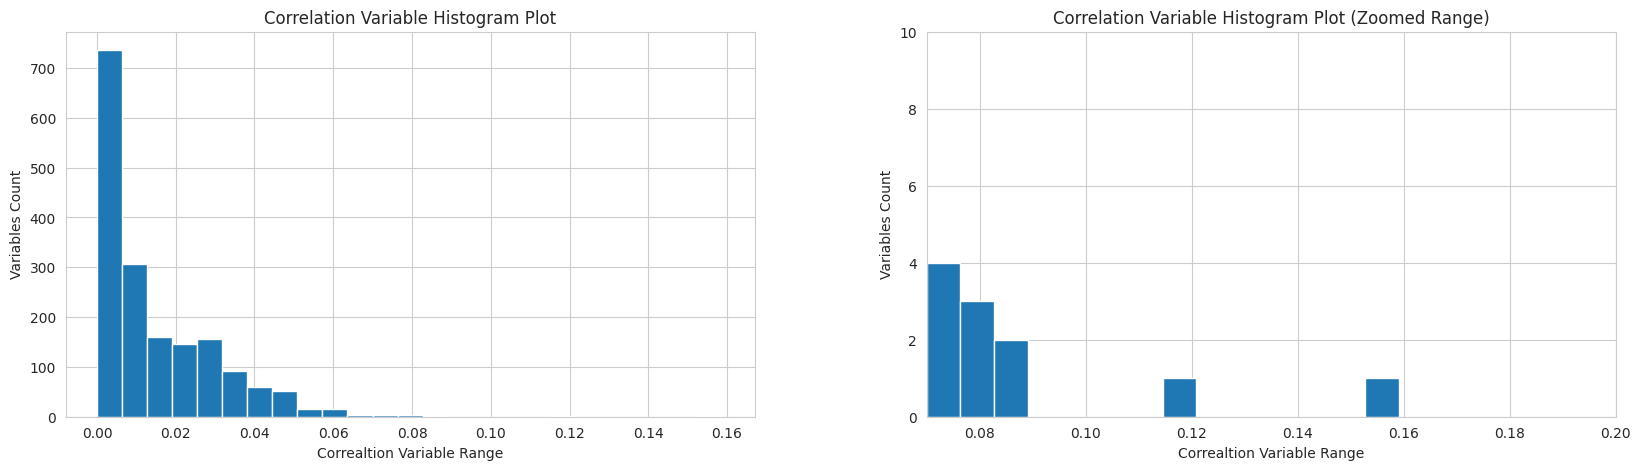

In [ ]:
# Lets understand the distribution of variables correlation wrt TARGET variable
sns.set_style('whitegrid')
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.25)
corr.drop('TARGET').abs().plot.hist(bins=25)
plt.xlabel('Correaltion Variable Range')
plt.ylabel('Variables Count')
plt.title("Correlation Variable Histogram Plot")

plt.subplot(1, 2, 2)
plt.subplots_adjust(wspace=0.25)
corr.drop('TARGET').abs().plot.hist(bins=25)
plt.xlabel('Correaltion Variable Range')
plt.ylabel('Variables Count')
plt.title("Correlation Variable Histogram Plot (Zoomed Range)")
plt.xlim([0.07,0.2])
plt.ylim([0,10])

plt.show()

**Observations and Conclusions:**
1. There is not a strong correlation between continuous variables and the TARGET variables which would show a linear relationship between variables and target.
2. EXT_SOURCE_2 and Target variable has maximum correlation with a pearson correlation value equal to 0.159
3. Histogram of variables correlation wrt TARGET variable is plotted. Histogram shows that most of the variables have a correlation coefficient less than 0.06.
4. Zoomed histogram plot of variables correlation coefficient wrt TARGET shows that very few count has correlation coefficient greater than 0.08
5. Correlation histogram clearly shows that the TARGET and the merged dataframes variable are non linear.
5. Lets dive deep into the first 10 continuous variables which show a high correlation wrt Target variable.

## Merged Application Train Continuous Variable Plots

### Continuous Variable 1: EXT_SOURCE_2

Continuous variable EXT_SOURCE_2 does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


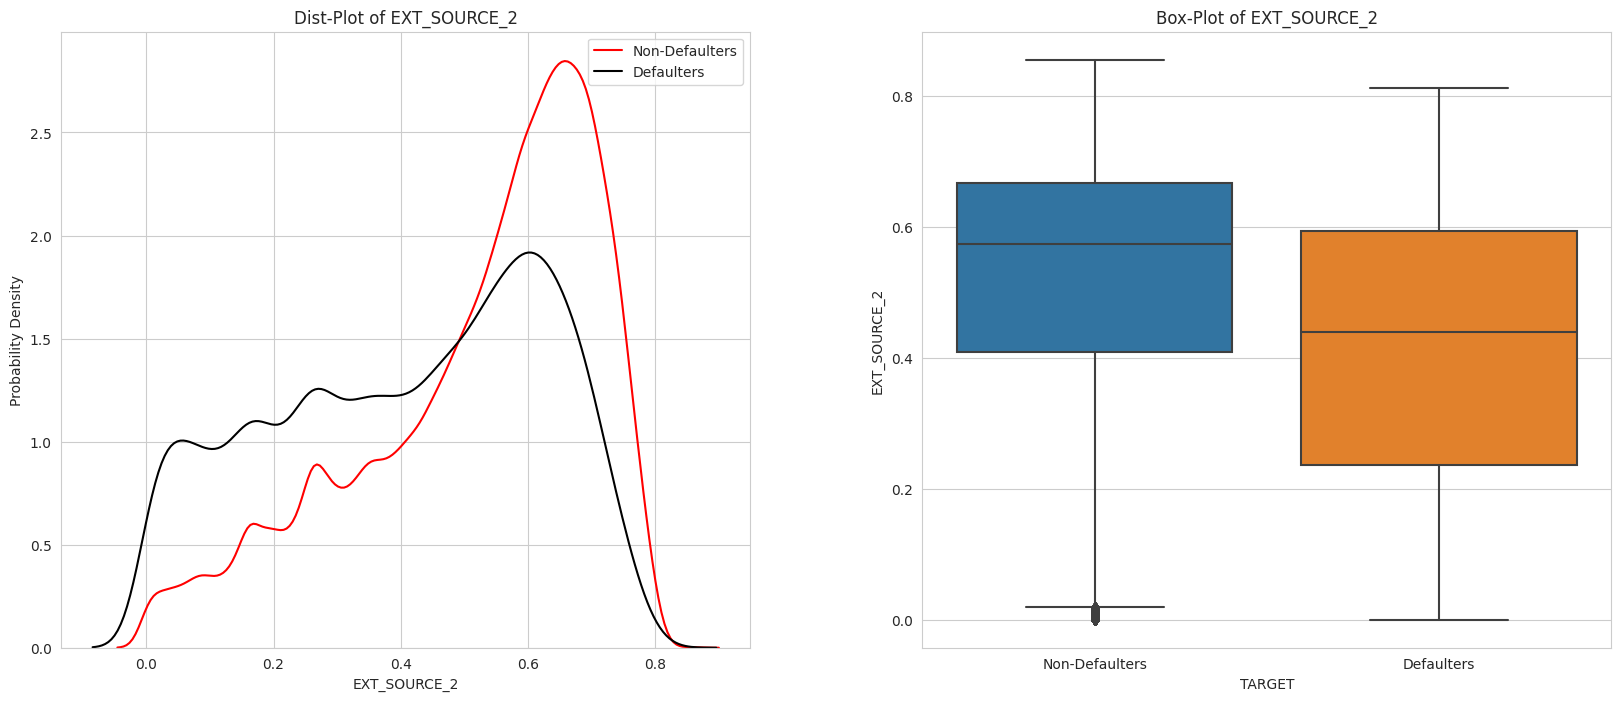

In [ ]:
# EXT_SOURCE_2
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[1])

**Observations and Conclusions :**  
1. This variable represents the normalized score of application from external data source.
2. This variable does not have any NaN values as merged dataframes NaN values are replaced by 0. Also as there are very few 0 values in this variable which represents that not much of NaN values were present in this variable before replacing by 0.
3. Probability density plot of non defaulters and defaulters is left skewed. Range of values for both of these categories lies between 0 to 0.9 . Non defaulters shows higher density within the range 0.6 to 0.8 than defaulters.
4. Intequertile range of non defaulters box plot is from 0.41 to 0.68 while that of defaulters is from 0.24 to 0.6. This is an evident that for smaller values of this variable, there are more chances of defaulting the loan.
5. Median values of non defaulters is higher than the defaulter. This value can be used for imputing the NaN samples.

### Continuous Variable 2: EXT_SOURCE_3

Continuous variable EXT_SOURCE_3 does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


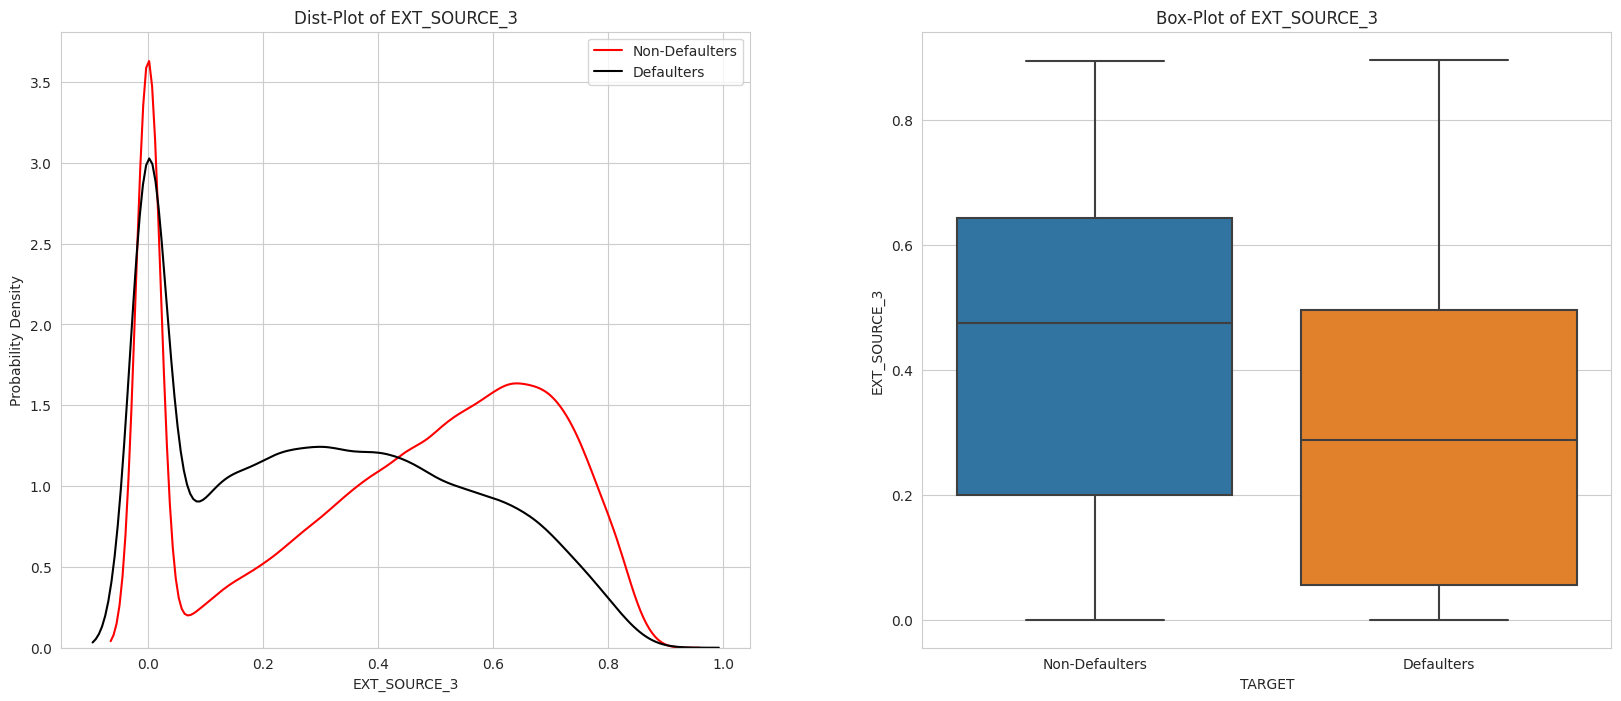

In [ ]:
# EXT_SOURCE_3
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[2])

**Observations and Conclusions :**  
1. This variable represents the normalized score of application from external data source.
2. Row samples of EXT_SOURCE_3  continuous variable have 19.83% have NaN values as observed from the EDA of application train. Out of these NaN valued row samples, around 90.69% are non defaulters while 9.31% are defaulters. As these NaN values are replaced by 0 in the merged dataframe we onserve a peak in the pdf for defaulters and non defaulters curve.
3. Range of PDF values for defaulters and non defaulters lies between 0 to 0.9 .
4. Intequertile range of non defaulters box plot is from 0.2 to 0.65 while that of defaulters is from 0.05 to 0.5. This is an evident that for smaller values of this variable, there are more chances of defaulting the loan.
5. Median values of non defaulters is higher than the defaulter.

### Continuous Variable 3: EXT_SOURCE_MUL

Continuous variable EXT_SOURCE_MUL does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


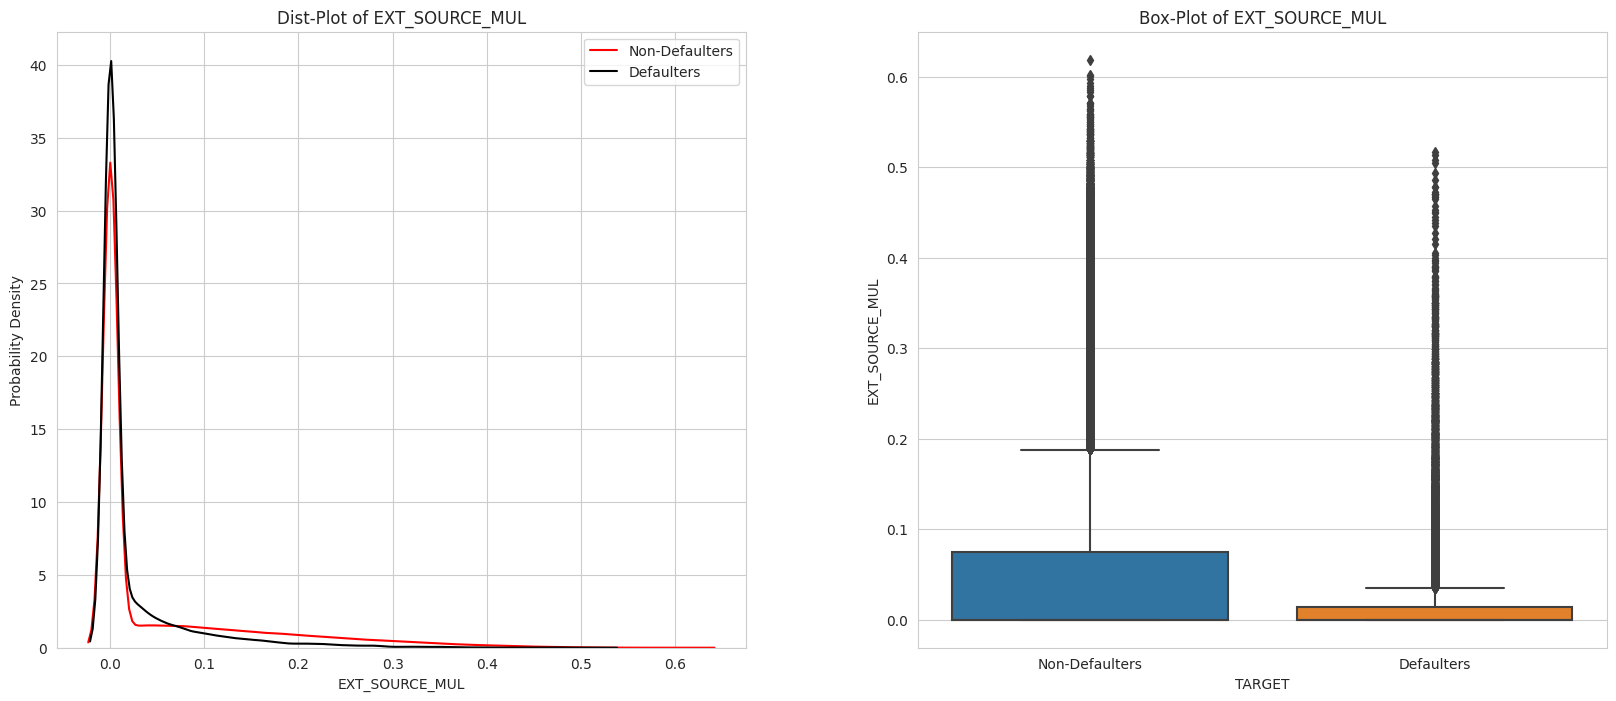

In [ ]:
# EXT_SOURCE_MUL
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[3])

**Observations and Conclusions :**  
1. This variable does not have any NaN values as merged dataframes NaN values are replaced by 0. Also as there are very high 0 values in this variable which represents that high NaN values were present in this variable before replacing by 0.
4. Intequertile range of non defaulters box plot is from 0 to 0.8 while that of defaulters is from 0 to 0.3. This is an evident that for smaller values of this variable, there are more chances of defaulting the loan.

### Continuous Variable 4: DAYS_CREDIT_MEAN

Continuous variable DAYS_CREDIT_MEAN does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


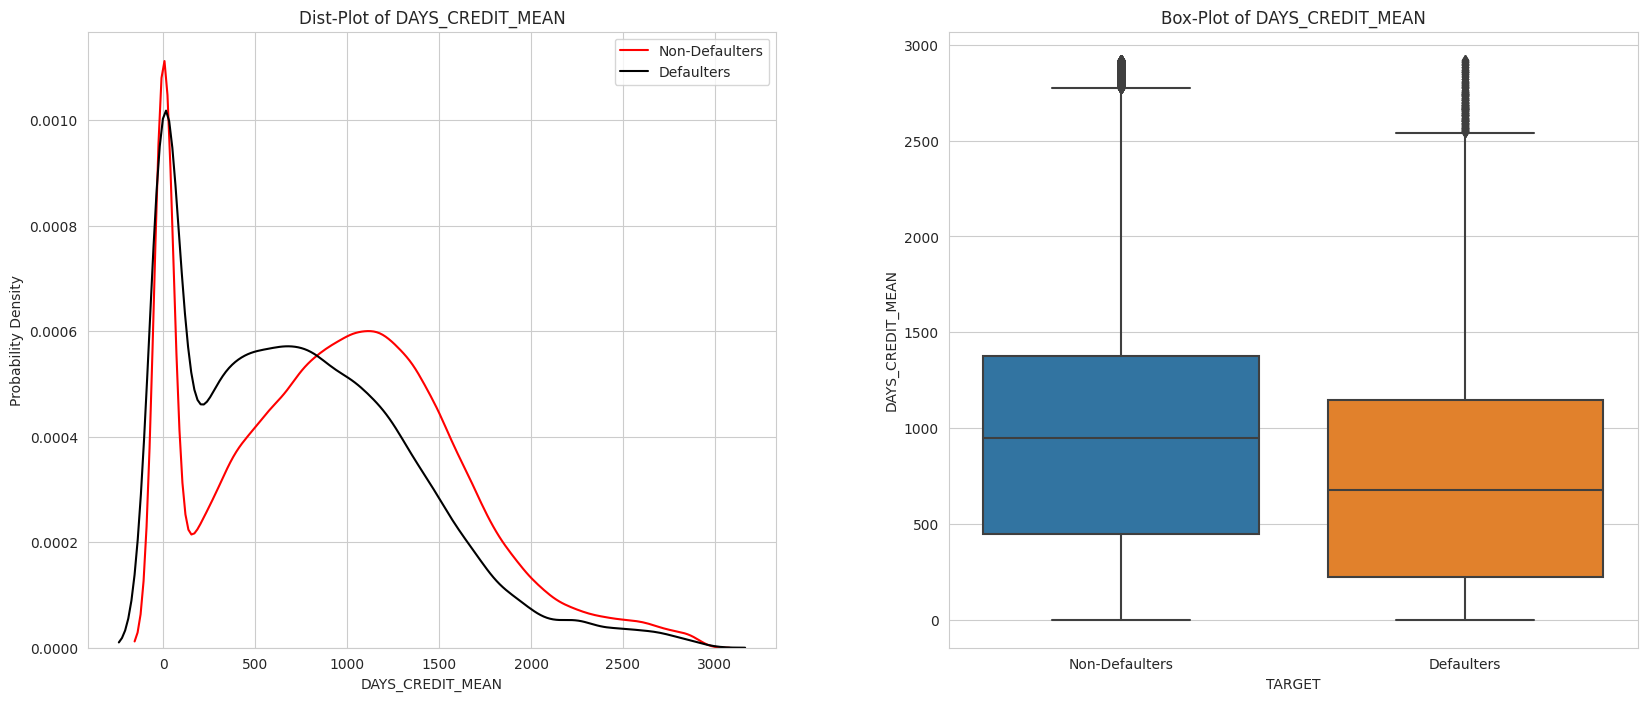

In [ ]:
# DAYS_CREDIT_MEAN
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[4])

**Observations and Conclusions :**  
1. This variable does not have any NaN values as merged dataframes NaN values are replaced by 0. Also as there are very high 0 values in this variable which represents that high NaN values were present in this variable before replacing by 0.
2. PDF shows that the range of values for this variable are from 0 to -3000.
4. Intequertile range of non defaulters box plot is from -400 to -1400 days while that of defaulters is from -300 to -1200. This is an evident that clients who have applied recently for credit in credit bureau tend to be more defaulter than non defaulter.

### Continuous Variable 5: EXT_SOURCE_MIN

Continuous variable EXT_SOURCE_MIN does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


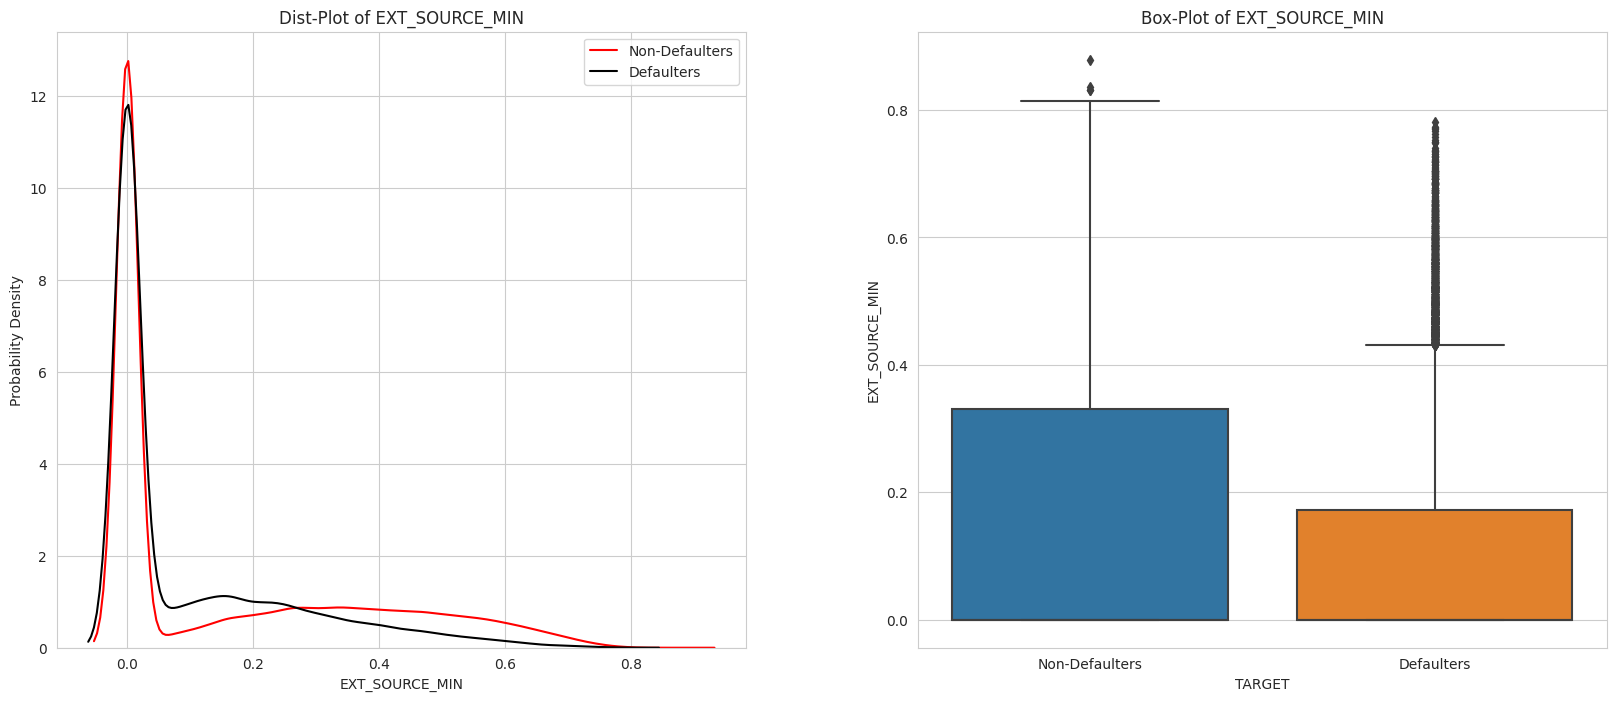

In [ ]:
# EXT_SOURCE_MIN
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[5])

**Observations and Conclusions :**  
1. This variable does not have any NaN values as merged dataframes NaN values are replaced by 0. Also as there are very high 0 values in this variable which represents that high NaN values were present in this variable before replacing by 0.
4. Intequertile range of non defaulters box plot is from 0 to 0.35 while that of defaulters is from 0 to 0.18. This is an evident that for smaller values of this variable, there are more chances of defaulting the loan.

### Continuous Variable 6: DAYS_BIRTH

Continuous variable DAYS_BIRTH does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


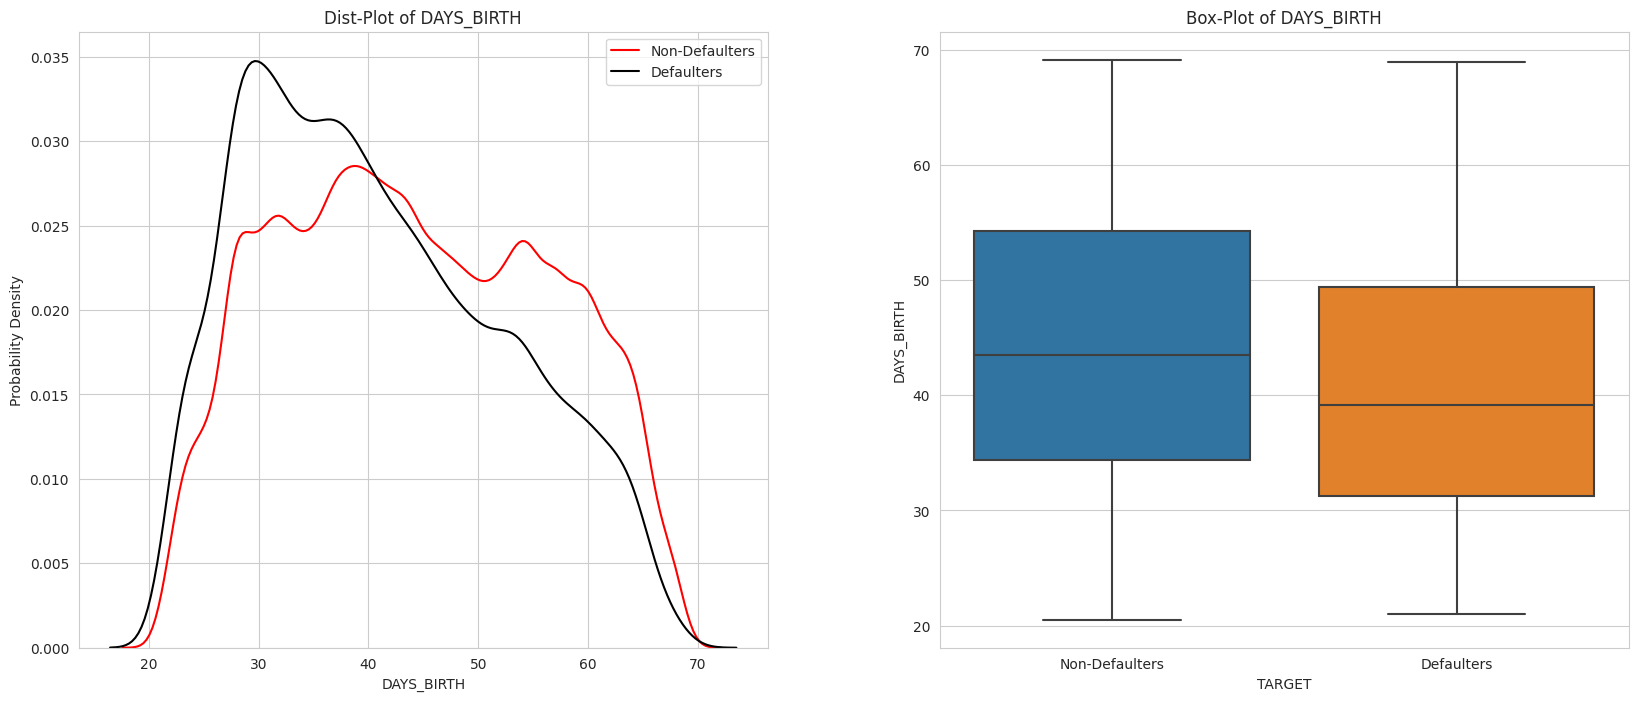

In [ ]:
# DAYS_BIRTH
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[6])

**Observations and Conclusions :**  
1. Row samples of age_birth continuous variable do not have any NaN values.
2. Probability density plot of non defaulters is uniformaly distributed while defaulters plot is right skewed. Also is is shows peak at around age 30.
3. Intequertile range of non defaulters box plot is from 35 to 53 age while that of defaulters is from 32 to 49. This is an evident that younger applicant are higher probable to be defaulter than non defaulter.
4. Minimum and maximum values of both the categories of applicants are same.

### Continuous Variable 7: CREDIT_ACTIVE_CLOSED_MEAN

Continuous variable CREDIT_ACTIVE_CLOSED_MEAN does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


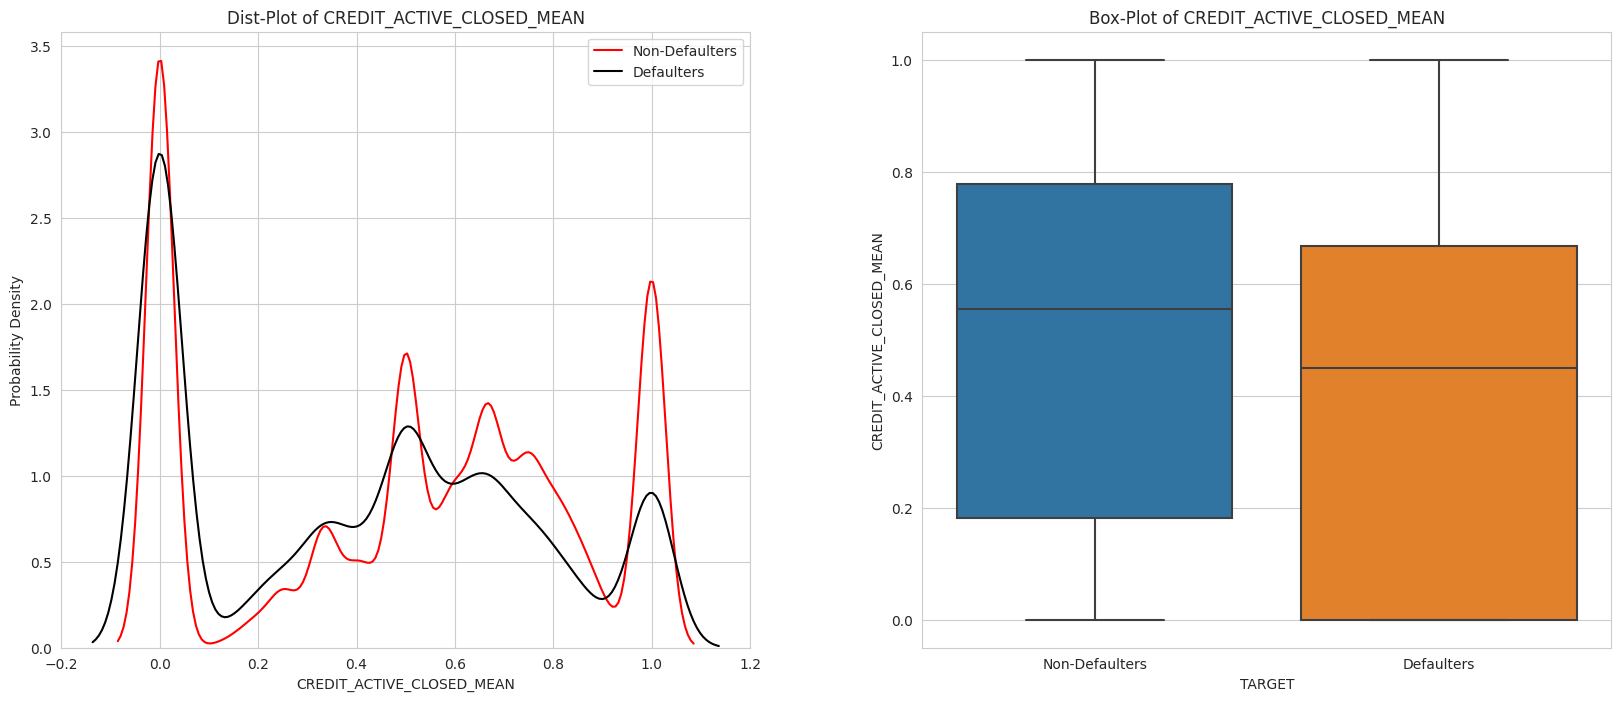

In [ ]:
# CREDIT_ACTIVE_CLOSED_MEAN
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[7])

**Observations and Conclusions :**  
1. This variable does not have any NaN values as merged dataframes NaN values are replaced by 0. Also as there are very high 0 values in this variable which represents that high NaN values were present in this variable before replacing by 0.
4. Intequertile range of non defaulters box plot is from 0.19 to 0.79 while that of defaulters is from 0 to 0.68. This is an evident that for smaller values of this variable, there are more chances of defaulting the loan.

### Continuous Variable 8: NAME_CONTRACT_STATUS_MEAN_ALL

Continuous variable NAME_CONTRACT_STATUS_MEAN_ALL does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


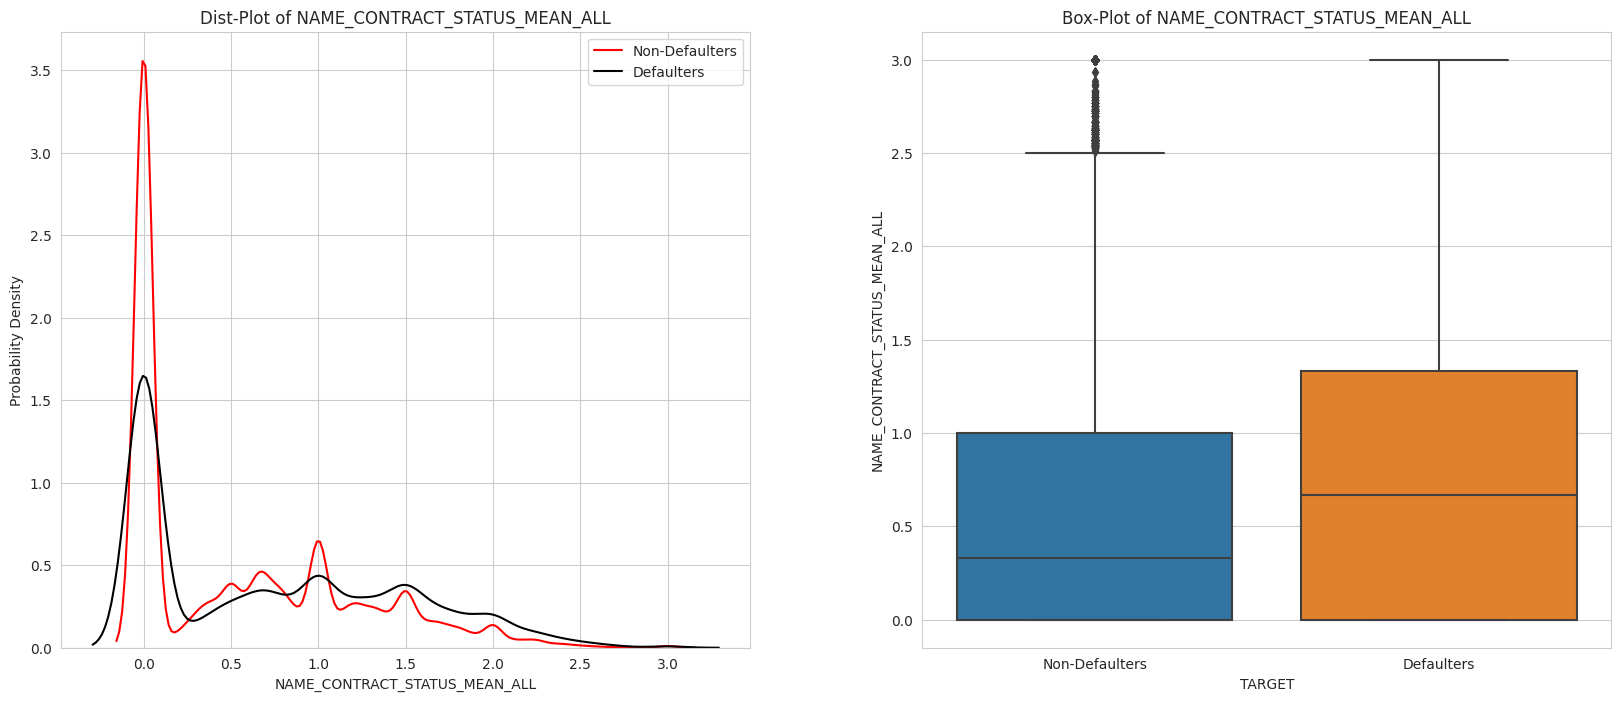

In [ ]:
# NAME_CONTRACT_STATUS_MEAN_ALL
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[8])

**Observations and Conclusions :**  
1. This variable does not have any NaN values as merged dataframes NaN values are replaced by 0. Also as there are very high 0 values in this variable which represents that high NaN values were present in this variable before replacing by 0.
4. Intequertile range of non defaulters box plot is from 0 to 1 while that of defaulters is from 0 to 1.45. This is an evident that for higher values of this variable, there are more chances of defaulting the loan.

### Continuous Variable 9: DAYS_CREDIT_MAX

Continuous variable DAYS_CREDIT_MAX does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


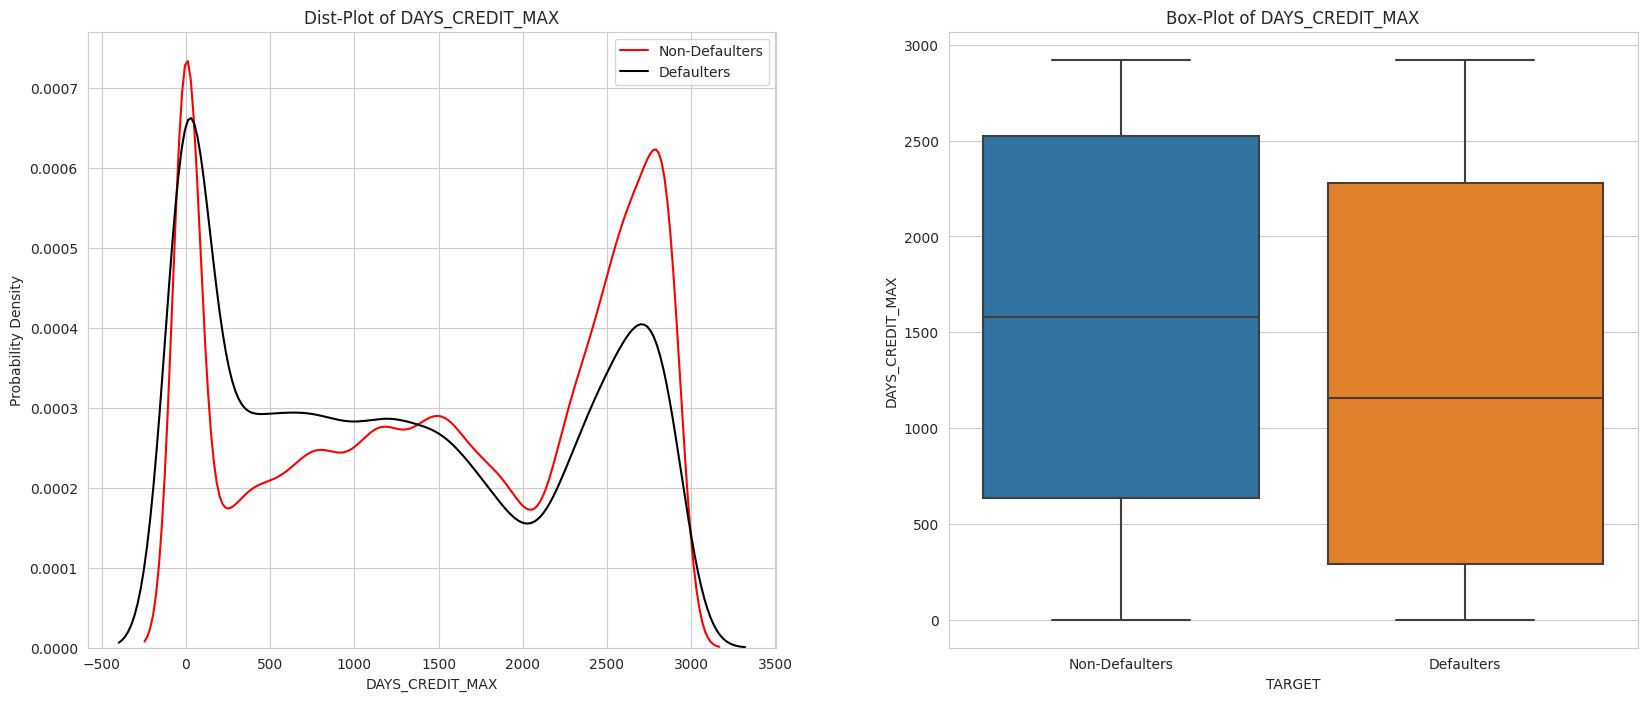

In [ ]:
# DAYS_CREDIT_MIN
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[9])

**Observations and Conclusions :**  
1. Row samples of DAYS_CREDIT_MAX continuous variable do not have any NaN values.
2. Intequertile range of non defaulters box plot is from 600 to 2500 days while that of defaulters is from 300 to 2300. This is an evident that latest credit applicants are higher probable to be defaulter than non defaulter.
3. Minimum and maximum values of both the categories of applicants are same.

### Continuous Variable 10: NAME_CONTRACT_STATUS_MEAN_LAST_5

Continuous variable NAME_CONTRACT_STATUS_MEAN_LAST_5 does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


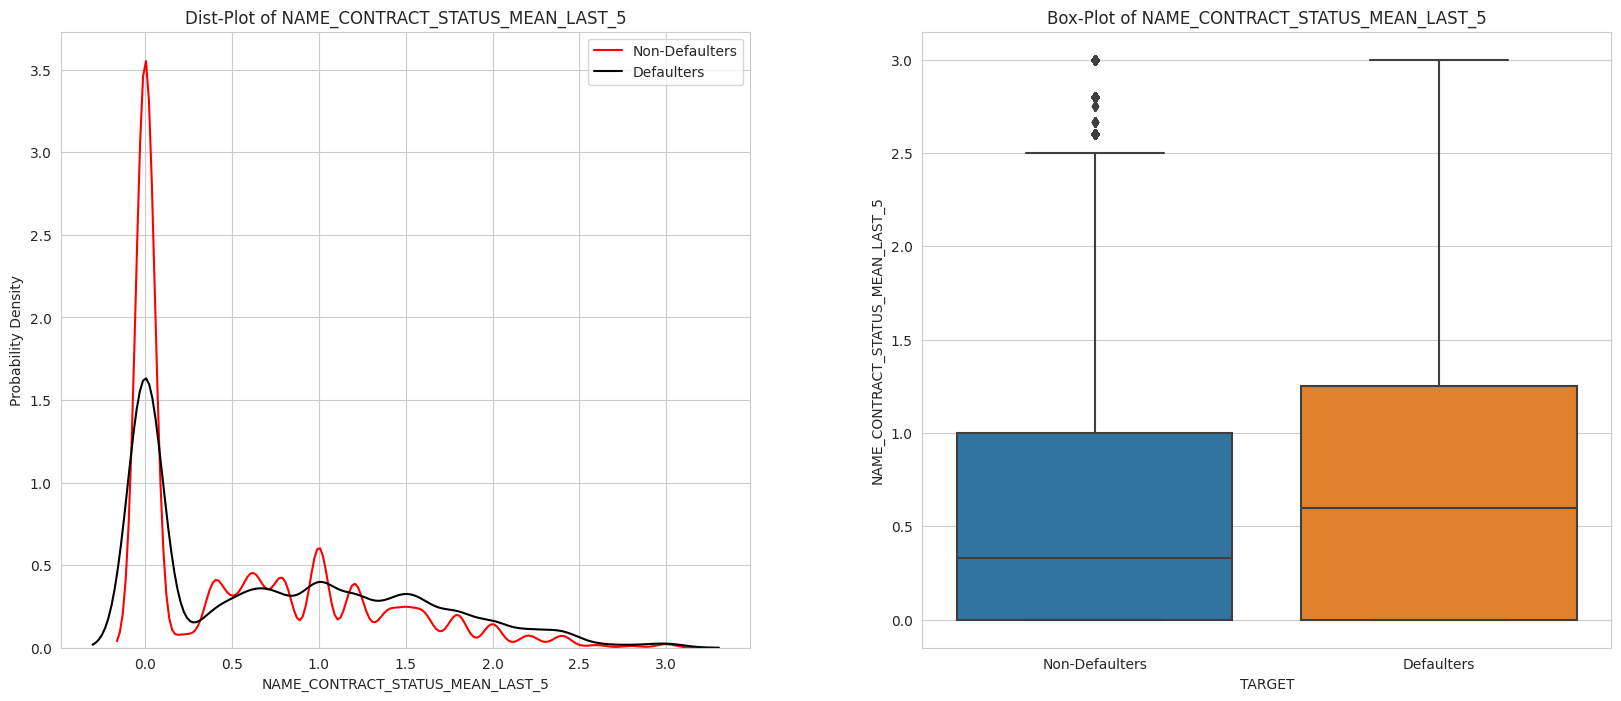

In [ ]:
# NAME_CONTRACT_STATUS_MEAN_LAST_5
plot_continuous_variables(application_train_merged,application_top_continuous_var_lst[10])

**Observations and Conclusions :**  
1. This variable does not have any NaN values as merged dataframes NaN values are replaced by 0. Also as there are very high 0 values in this variable which represents that high NaN values were present in this variable before replacing by 0.
4. Intequertile range of non defaulters box plot is from 0 to 1 while that of defaulters is from 0 to 1.3. This is an evident that for higher values of this variable, there are more chances of defaulting the loan.

## Merged Application Train Top Continuous Variables Pair Plot

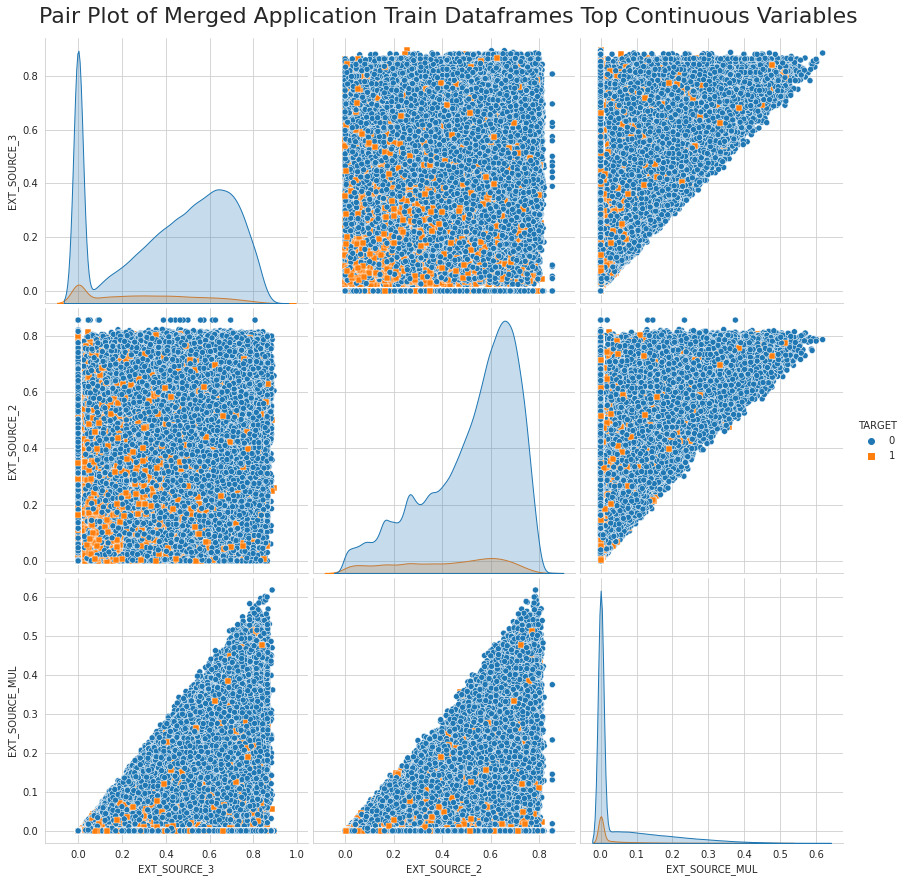

In [ ]:
df=application_train_merged[["TARGET","EXT_SOURCE_3","EXT_SOURCE_2","EXT_SOURCE_MUL"]]
pairPlotFn(df,"Merged Application Train")

**Observations and Conclusions:**
1. In this pair plot Merged Application Train dataframes top 3 continuous variables correlated with Targer variable are plotted. These top 3 continuous variables are "EXT_SOURCE_3","EXT_SOURCE_2","EXT_SOURCE_MUL".
2. 0 represents the non defaulters while 1 represents the defaulters.
3. None of the subplots of this pair plot shows a clear linear seperation between the Target variables defaulters and non defaulters categoris.
4. Pair plot shows that, defaulters have smaller values of all the 3 variables compared to the non defaulters. However there are small percentage of defaulter values which do not follows this.

# Conclusions From Data processing and featurization
1. Observations from EDA consisting of saturating the values of anamolies of variables, converting the days values of variable to years, combining the almost 0 count categorical variables into a single low count variables etc. are used for data preprocessing.
2. Categorical variables are encoded using One hot encoding, label encoding and frequency encoding. Based on the categories and behavior of categorical variable data, these variables are encoded.
3. New features are formed based on the domain knowledge and by refering the literature.
4. Aggregation techniques are used based on the domain knowledge to form the aggregated dataframes.
5. Individual aggregated dataframes are merged to form a merged application train and application test dataframes.
6. Based on the literature, NaN values are imputed with 0.
7. Variables of merged application train dataframe do not show a linear behavior with the Target. There are large number of variables which shows a very less correlation (<0.06) wrt Target.
8. Non linear ml algorithms should yield a good performance metric for the problem statement.
9. There are 1770 variables in the final merged dataframe. It is important to do a feature selection while building the model.